In [35]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
os.sys.path.append("C:\\Users\\mplitt\\s2p_processing")
import utilities as u
import preprocessing as pp
import single_session_plots as ssp
import numpy as np
import SimilarityMatrixAnalysis as sm
import PlaceCellAnalysis as pc
import scipy as sp
import matplotlib.pyplot as plt
import suite2p as s2p
import s2p_preprocessing as s2p_pp
import h5py

%load_ext autoreload
%autoreload 2

# %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pp.load_session_db(twop_dir = "G:\\My Drive\\2P_Data\\Syt3KO")
# df = pp.load_session_db()
df = df[df['RewardCount']>20]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

 

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [3]:
mouse = '4343705.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

MouseName  DateFolder  SessionNumber               Track  RewardCount  \
3066  4343705.1  13_01_2020              2  TwoTower_noTimeout          100   
3094  4343705.1  15_01_2020              2  TwoTower_noTimeout          100   

      Imaging ImagingRegion   DateTime  \
3066        1           CA1 2020-01-13   
3094        1           CA1 2020-01-15   

                                              data file scanfile  \
3066  G:\My Drive\VR_Data\TwoTower\4343705.1\13_01_2...     None   
3094  G:\My Drive\VR_Data\TwoTower\4343705.1\15_01_2...     None   

                                                scanmat  \
3066  G:\My Drive\2P_Data\Syt3KO\4343705.1\13_01_202...   
3094  G:\My Drive\2P_Data\Syt3KO\4343705.1\15_01_202...   

                                              s2pfolder  
3066  G:\My Drive\2P_Data\Syt3KO\4343705.1\13_01_202...  
3094  G:\My Drive\2P_Data\Syt3KO\4343705.1\15_01_202...

In [4]:
# load s2p ops

sess = df_mouse.iloc[-1]
print(sess['s2pfolder'])

G:\My Drive\2P_Data\Syt3KO\4343705.1\15_01_2020\TwoTower_noTimeout\TwoTower_noTimeout_002_004\suite2p


In [5]:
ops = np.load(os.path.join(sess['s2pfolder'],'ops1.npy')).item()
for k in ops.keys():
    print(k)

look_one_level_down
fast_disk
delete_bin
mesoscan
h5py
h5py_key
save_path0
save_folder
subfolders
nplanes
nchannels
functional_chan
tau
fs
force_sktiff
preclassify
save_mat
combined
aspect
do_bidiphase
bidiphase
do_registration
keep_movie_raw
nimg_init
batch_size
maxregshift
align_by_chan
reg_tif
reg_tif_chan2
subpixel
smooth_sigma
th_badframes
pad_fft
nonrigid
block_size
snr_thresh
maxregshiftNR
1Preg
spatial_hp
pre_smooth
spatial_taper
roidetect
sparse_mode
diameter
spatial_scale
connected
nbinned
max_iterations
threshold_scaling
max_overlap
high_pass
inner_neuropil_radius
min_neuropil_pixels
allow_overlap
chan2_thres
baseline
win_baseline
sig_baseline
prctile_baseline
neucoeff
xrange
yrange
data_path
save_path
ops_path
reg_file
reg_file_chan2
meanImg
meanImg_chan2
nframes
Ly
Lx
yblock
xblock
nblocks
NRsm
refImg
yoff
xoff
corrXY
yoff1
xoff1
corrXY1
badframes
regPC
regDX
tPC
max_proj
Lyc
Lxc
Vmap
Vcorr
spatscale_pix
Vmax
ihop
Vsplit
meanImgE


In [8]:
%matplotlib qt
f,ax = plt.subplots(1,2,figsize=[15,5])
ax[0].imshow(ops['meanImg'],cmap='gray')
ax[1].imshow(ops['meanImg_chan2'],cmap='gray')
f.show()

In [12]:
ops = s2p.utils.enhanced_mean_image(ops)

In [13]:
%matplotlib qt
f,ax = plt.subplots(1,2,figsize=[15,5])
ax[0].imshow(ops['meanImgE'],cmap='gray')
ax[1].imshow(ops['meanImgE_chan2'],cmap='gray')
f.show()

### try to align zstacks

In [29]:
def sbx_to_frames(filename,k=0,N=None):
    return np.transpose(s2p_pp.sbxread(filename,k=k,N=N),axes=(0,3,2,1))

In [65]:
data = s2p_pp.sbxread(os.path.join(predir,"pre_000_000.mat")[:-4])

1630208 7799
0


(2, 796, 512, 7799)


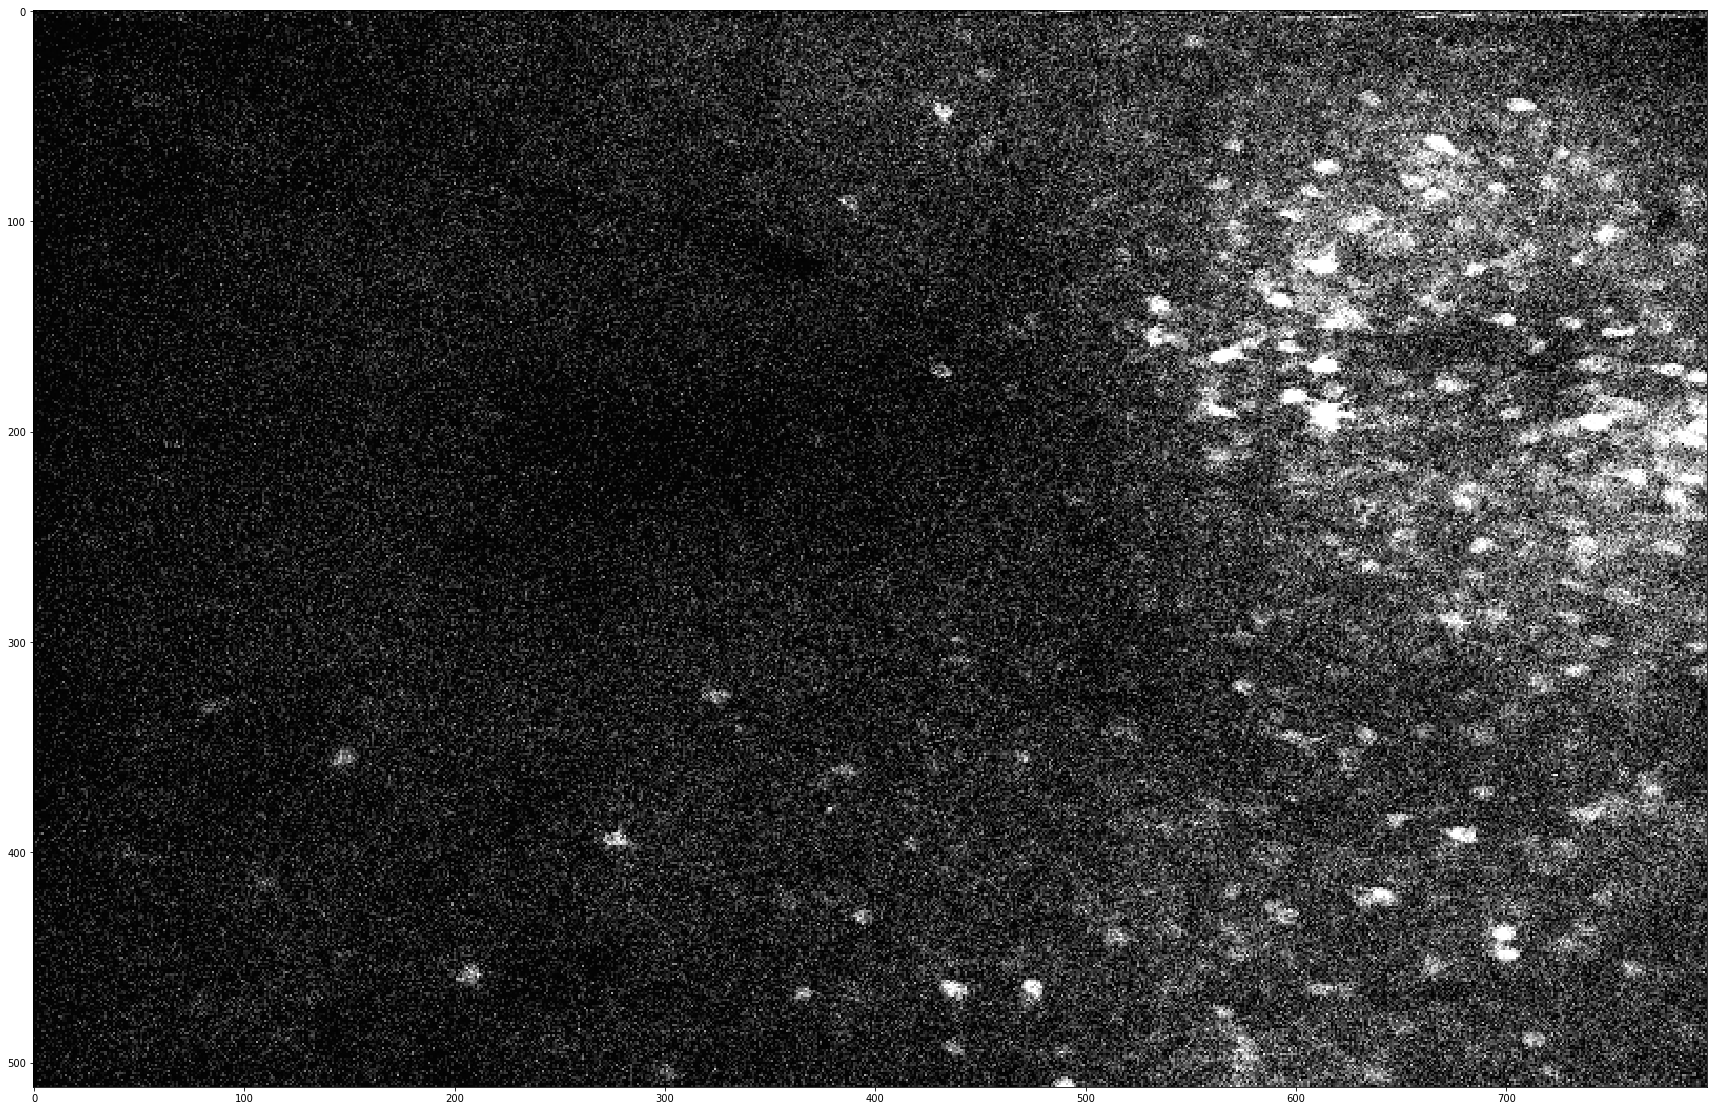

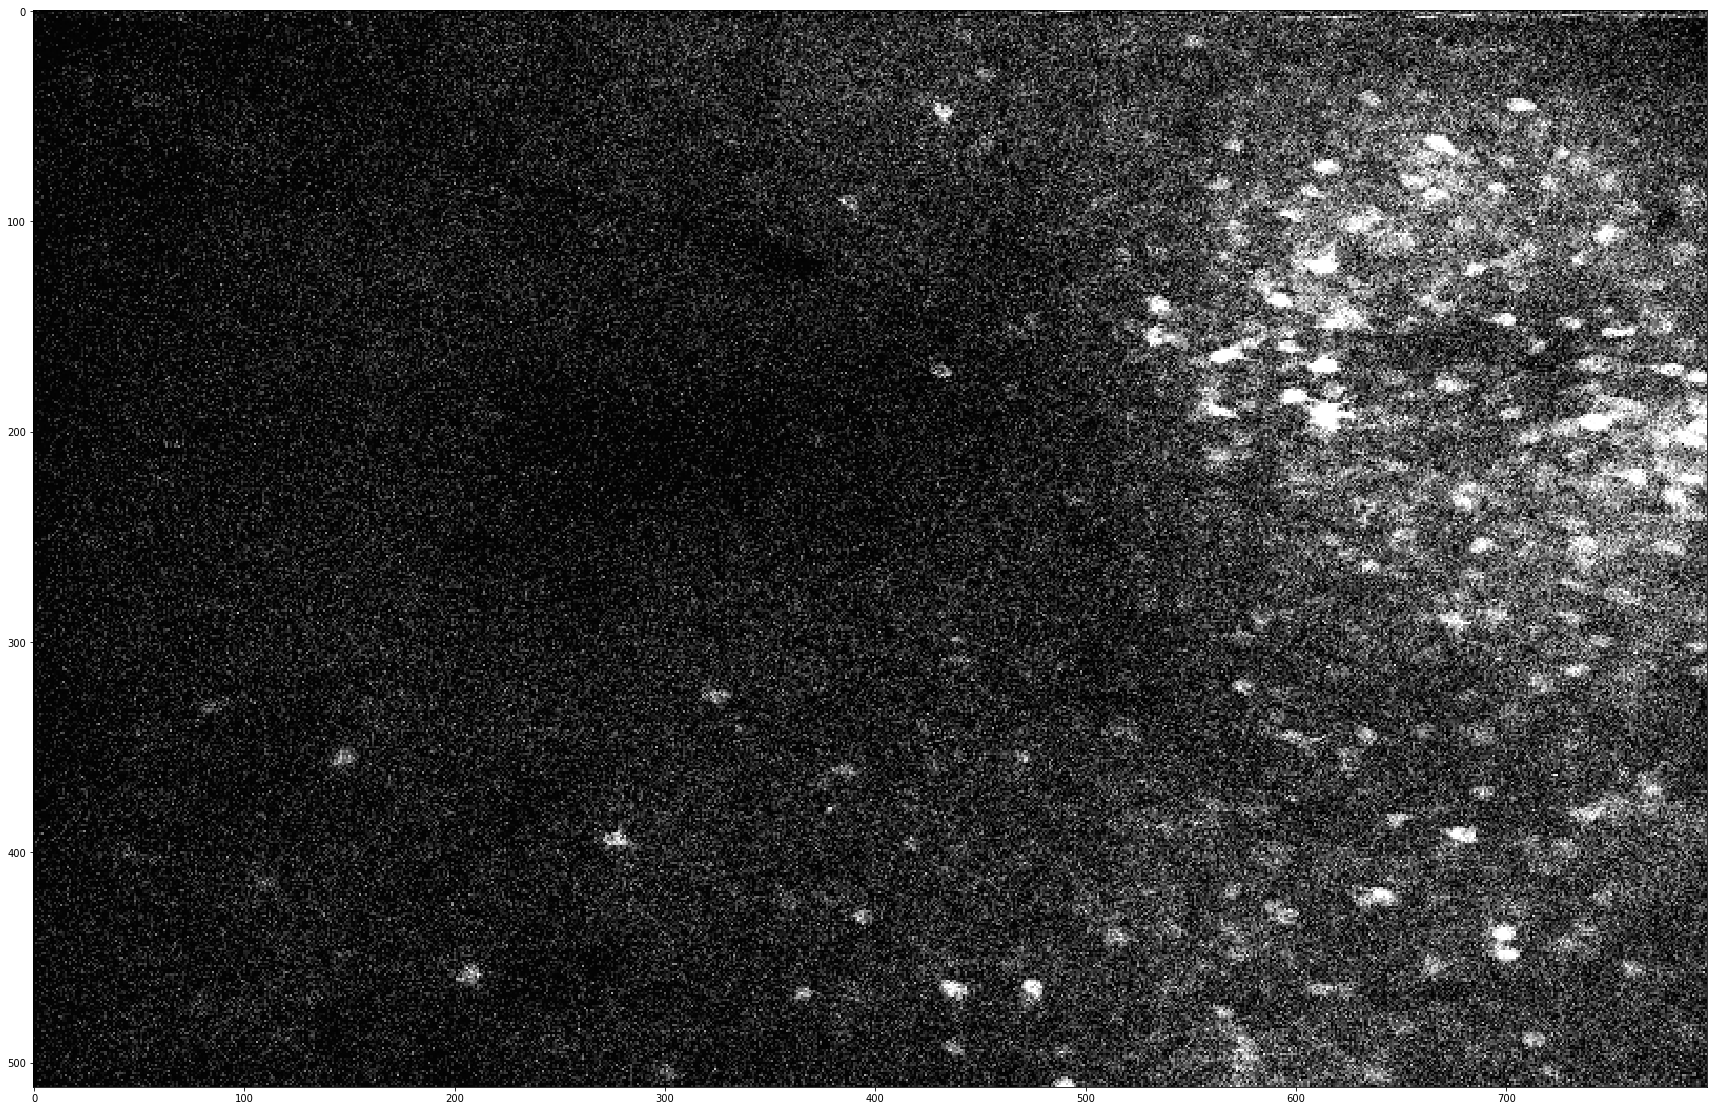

In [67]:
print(data.shape)
fig,ax = plt.subplots(figsize=[30,20])
ax.imshow(data[0,:,:,200].T,cmap='gray')

dataT = np.transpose(data,axes=(0,3,2,1))
fig,ax = plt.subplots(figsize=[30,20])
ax.imshow(dataT[0,200,:,:],cmap='gray')

In [68]:
print(os.path.join(predir,"pre_000_000"))

E:\4343705.1\15_01_2020\pre\pre_000_000


In [73]:
%matplotlib inline

predir = "E:\\4343705.1\\15_01_2020\\pre"


info = s2p_pp.loadmat(os.path.join(predir,"pre_000_000.mat"))
# print(info['config'])
_knobby_sched = np.array(info['config']['knobby']['schedule'])
knobby_sched = np.zeros([_knobby_sched.shape[0]+2,])
knobby_sched[1:-1]=_knobby_sched[:,-1]
knobby_sched[-1]=info['max_idx']

print(knobby_sched)

ops['biphase']=0
ops['do_biphase']=False
stack = np.zeros([info['nChan'],knobby_sched.shape[0]-1,info['sz'][0],info['sz'][1]])
for i, (first,last) in enumerate(zip(knobby_sched[:-1].tolist(),knobby_sched[1:].tolist())):
    data =s2p_pp.sbxread(os.path.join(predir,"pre_000_000"),first+2,last-first-2)
    data = np.transpose(data,axes=(0,3,2,1))
    print(data.shape)
    for chan in range(info['nChan']):
        refimg = s2p.register.pick_init(ops,frames=np.squeeze(data[chan,:,:,:]))
#         frames = np.squeeze(data[0,:,:,:])
#         refimg = s2p.register.pick_init_init(frames)
        stack[chan,i,:,:]=refimg
#     f,ax = plt.subplots(1,2,figsize=[15,5])
#     for chan in range(info['nChan']):
#         ref_img = s2p.register.pick_init(ops,frames=np.squeeze(data[chan,:,:,:]))
#         ax[chan].imshow(ref_img,cmap='gray')
#         stack[chan,i,:,:]=ref_img
    





    
# look at pre z stack

# check info file

# look every 300 frames

# convert to h5

# motion correct

# make new z stack h5


[   0.  300.  600.  900. 1200. 1500. 1800. 2100. 2400. 2700. 3000. 3300.
 3600. 3900. 4200. 4500. 4800. 5100. 5400. 5700. 6000. 6300. 6600. 6900.
 7200. 7500. 7799.]
1630208 298.0
3260416
(2, 298, 512, 796)
1630208 298.0
492322816
(2, 298, 512, 796)
1630208 298.0
981385216
(2, 298, 512, 796)
1630208 298.0
1470447616


KeyboardInterrupt: 

In [33]:
print(stack.shape)

(2, 26, 512, 796)


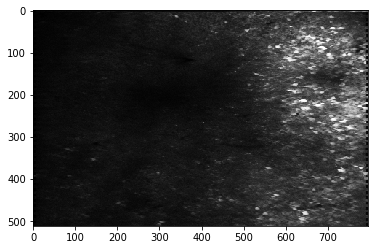

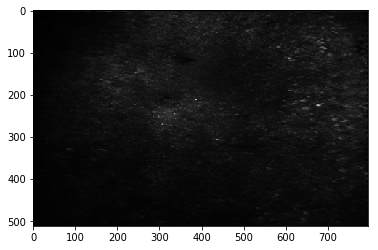

In [45]:
%matplotlib inline
for chan in range(info['nChan']):
    fname = os.path.join(predir,"pre_000_000_chan%i.h5" % chan)
    with h5py.File(fname,"w") as f:
        dset = f.create_dataset("data",stack.shape[1:],dtype='int16')
        fig,ax = plt.subplots()
        ax.imshow(stack[chan,1,:,:],cmap='gray')
        dset[:,:,:]=np.squeeze(stack[chan,:,:,:])
        
        f.flush()

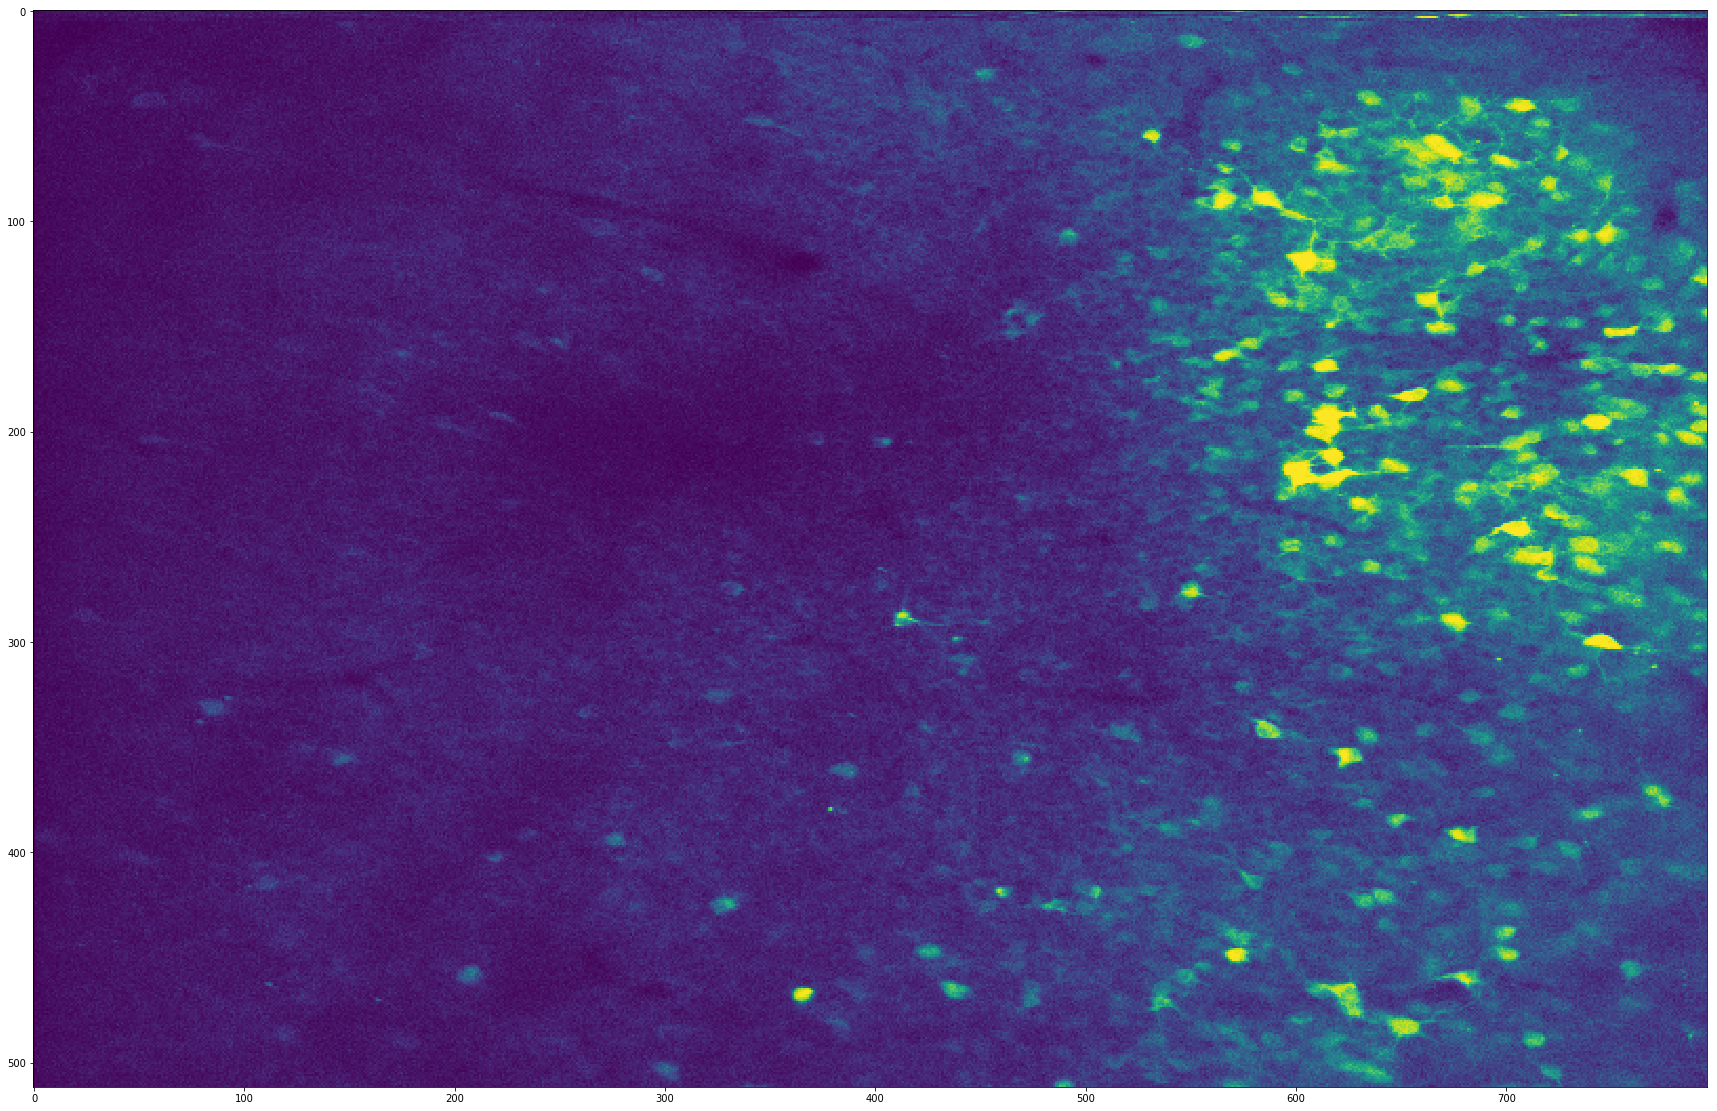

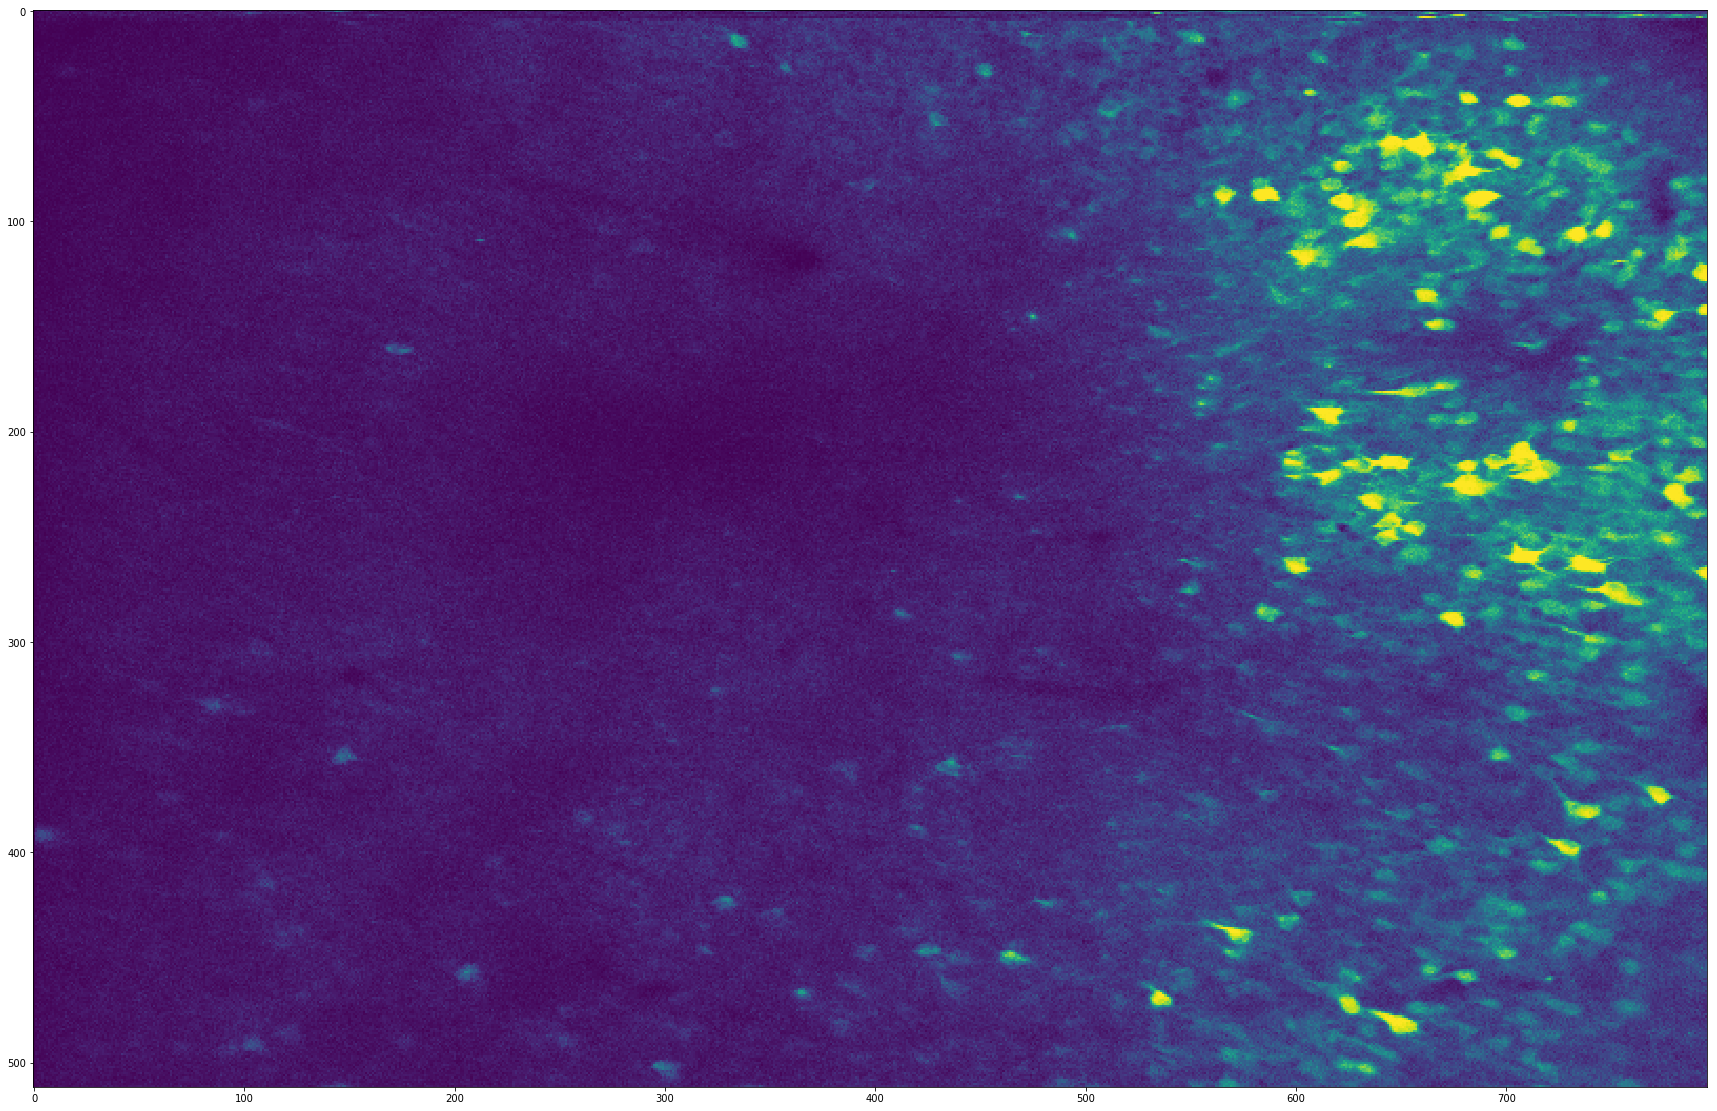

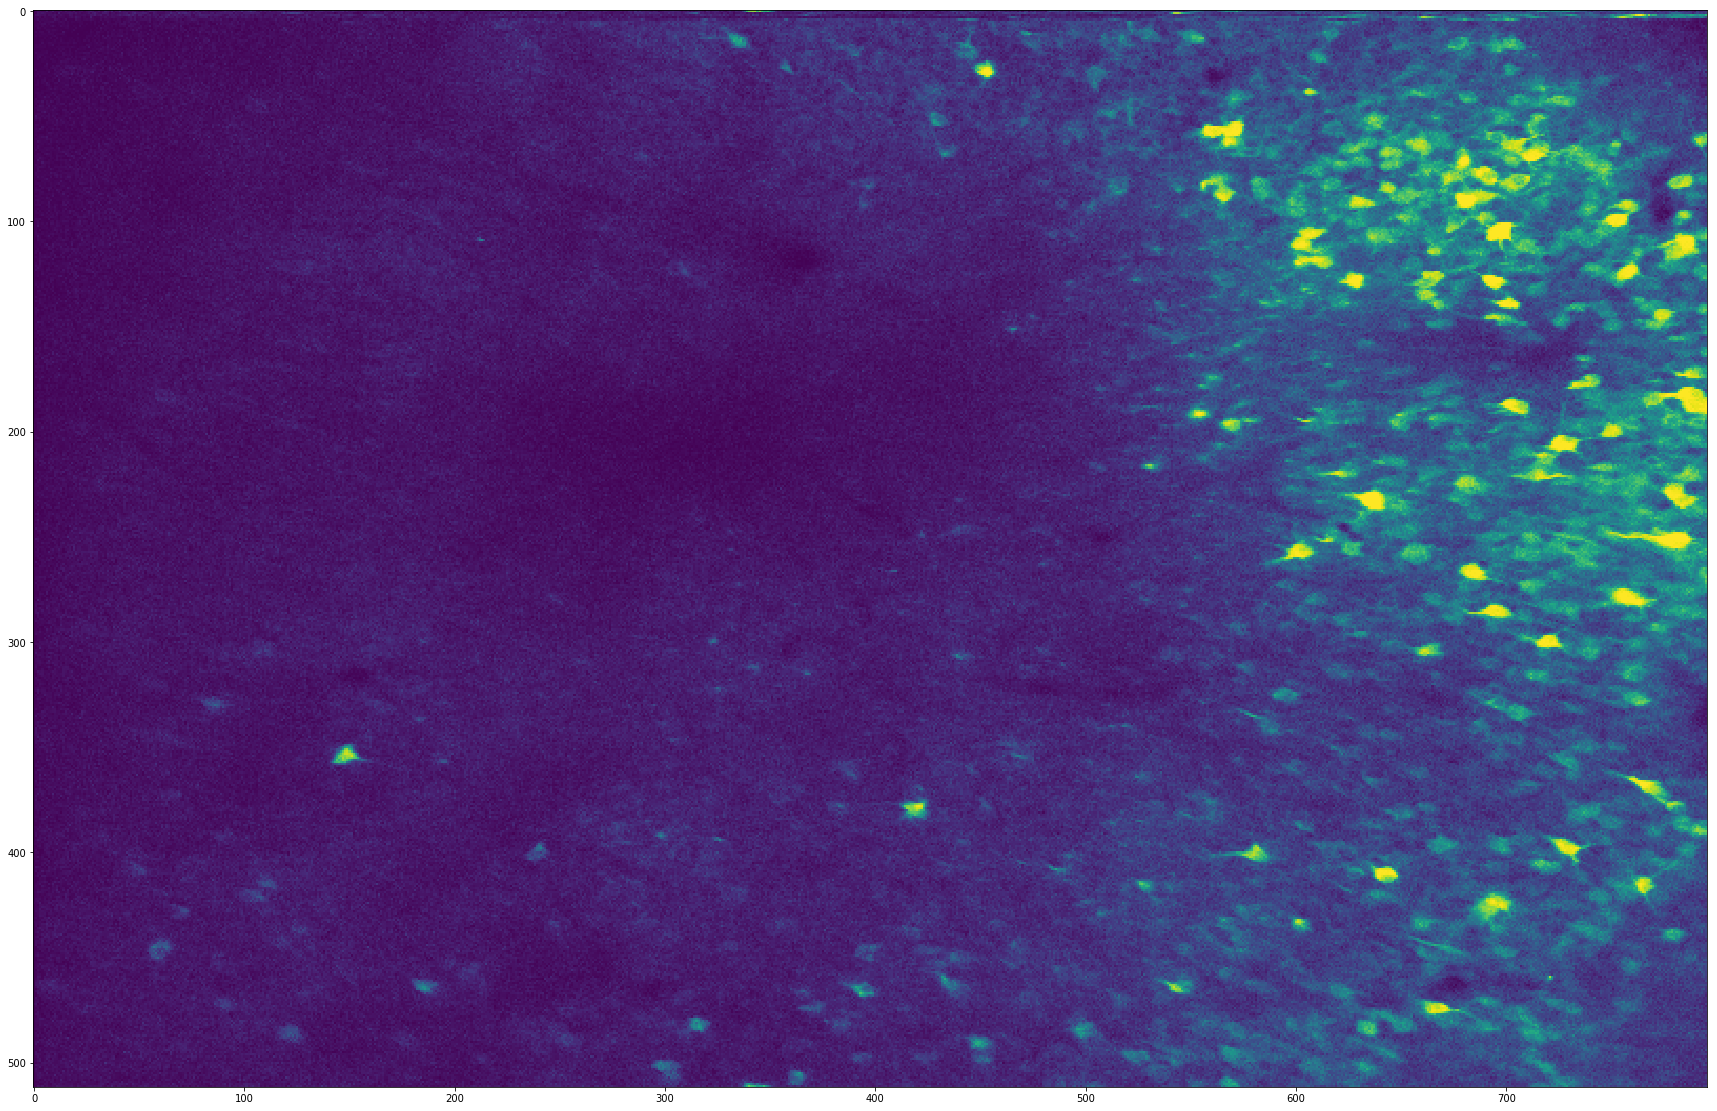

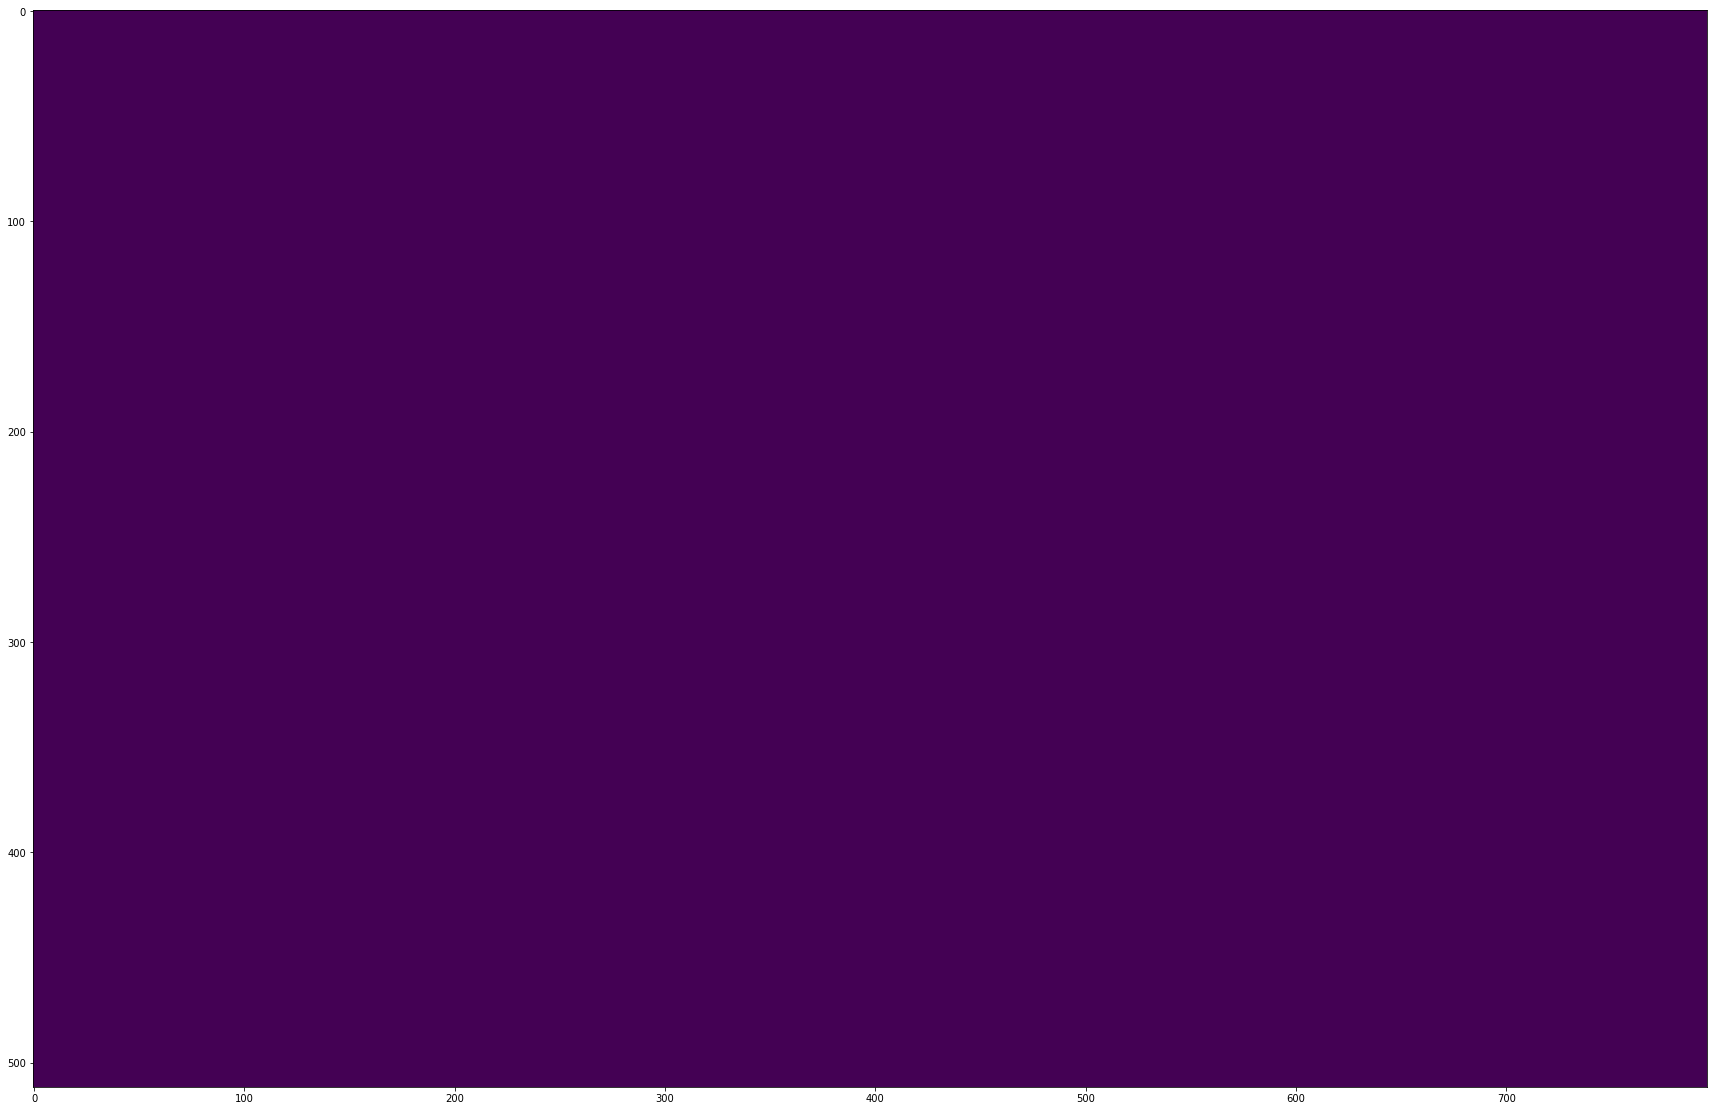

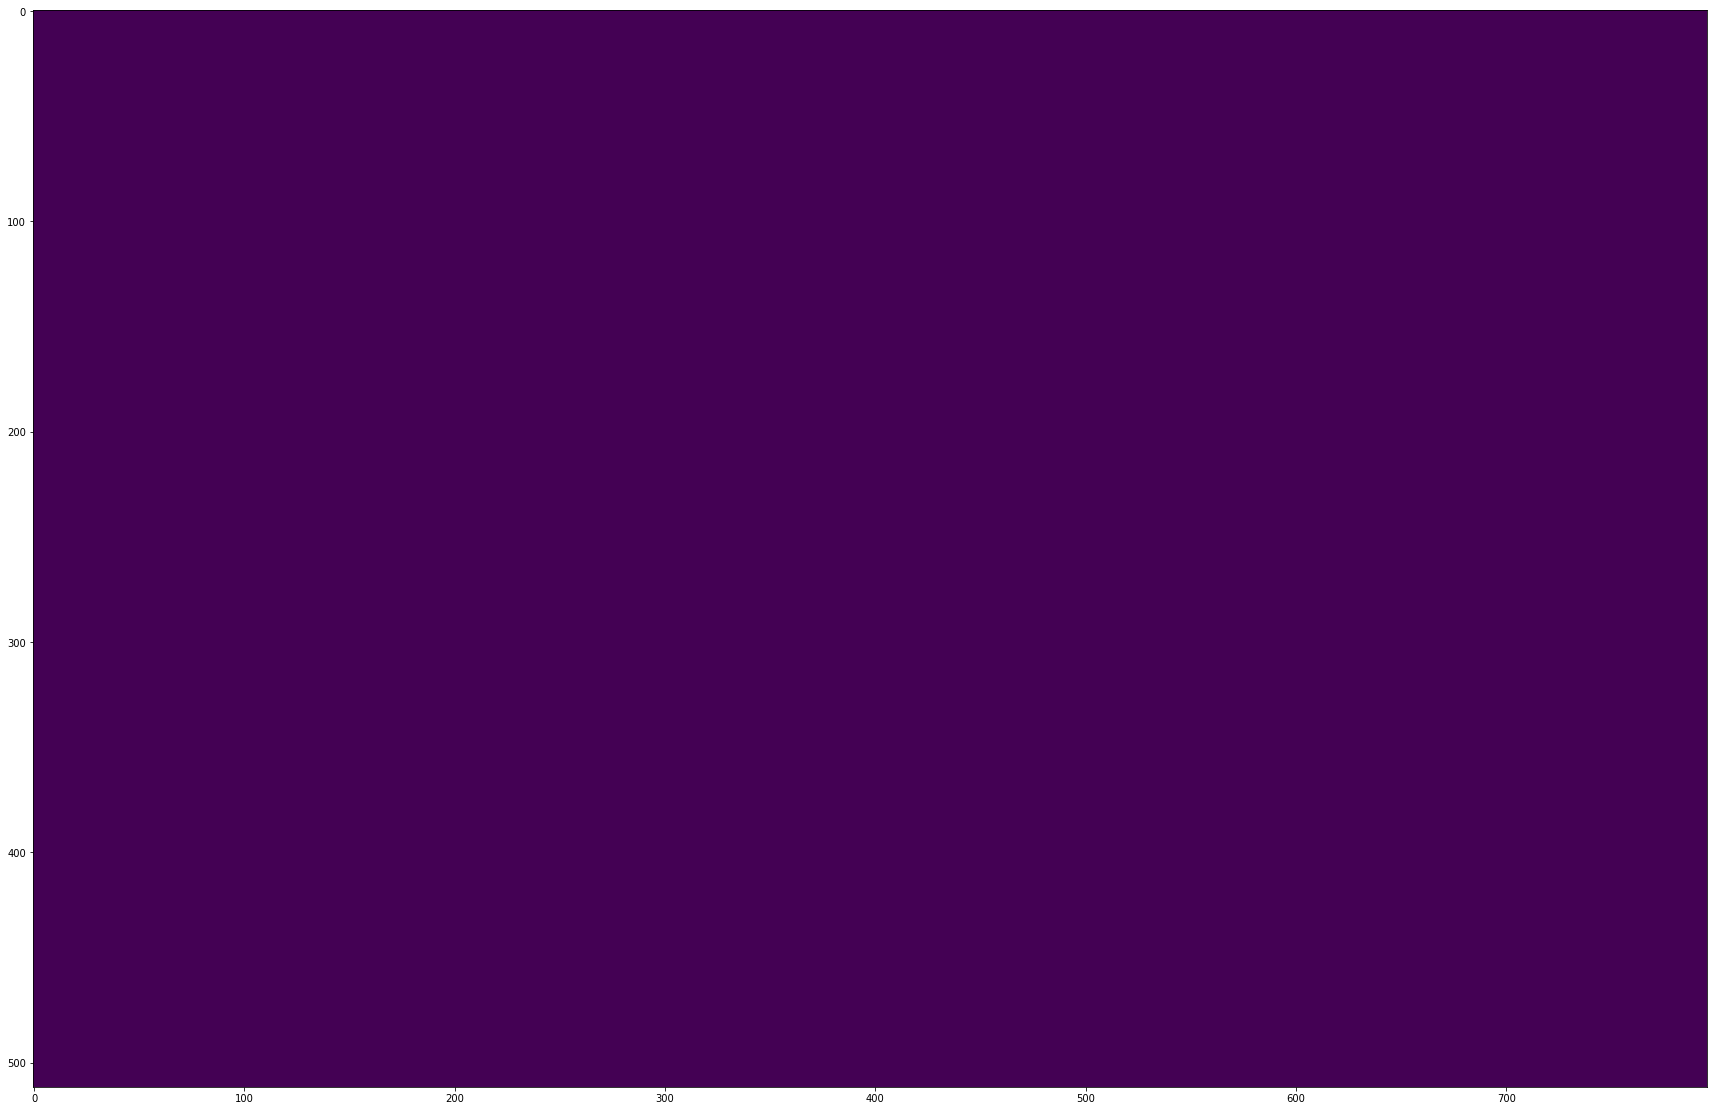

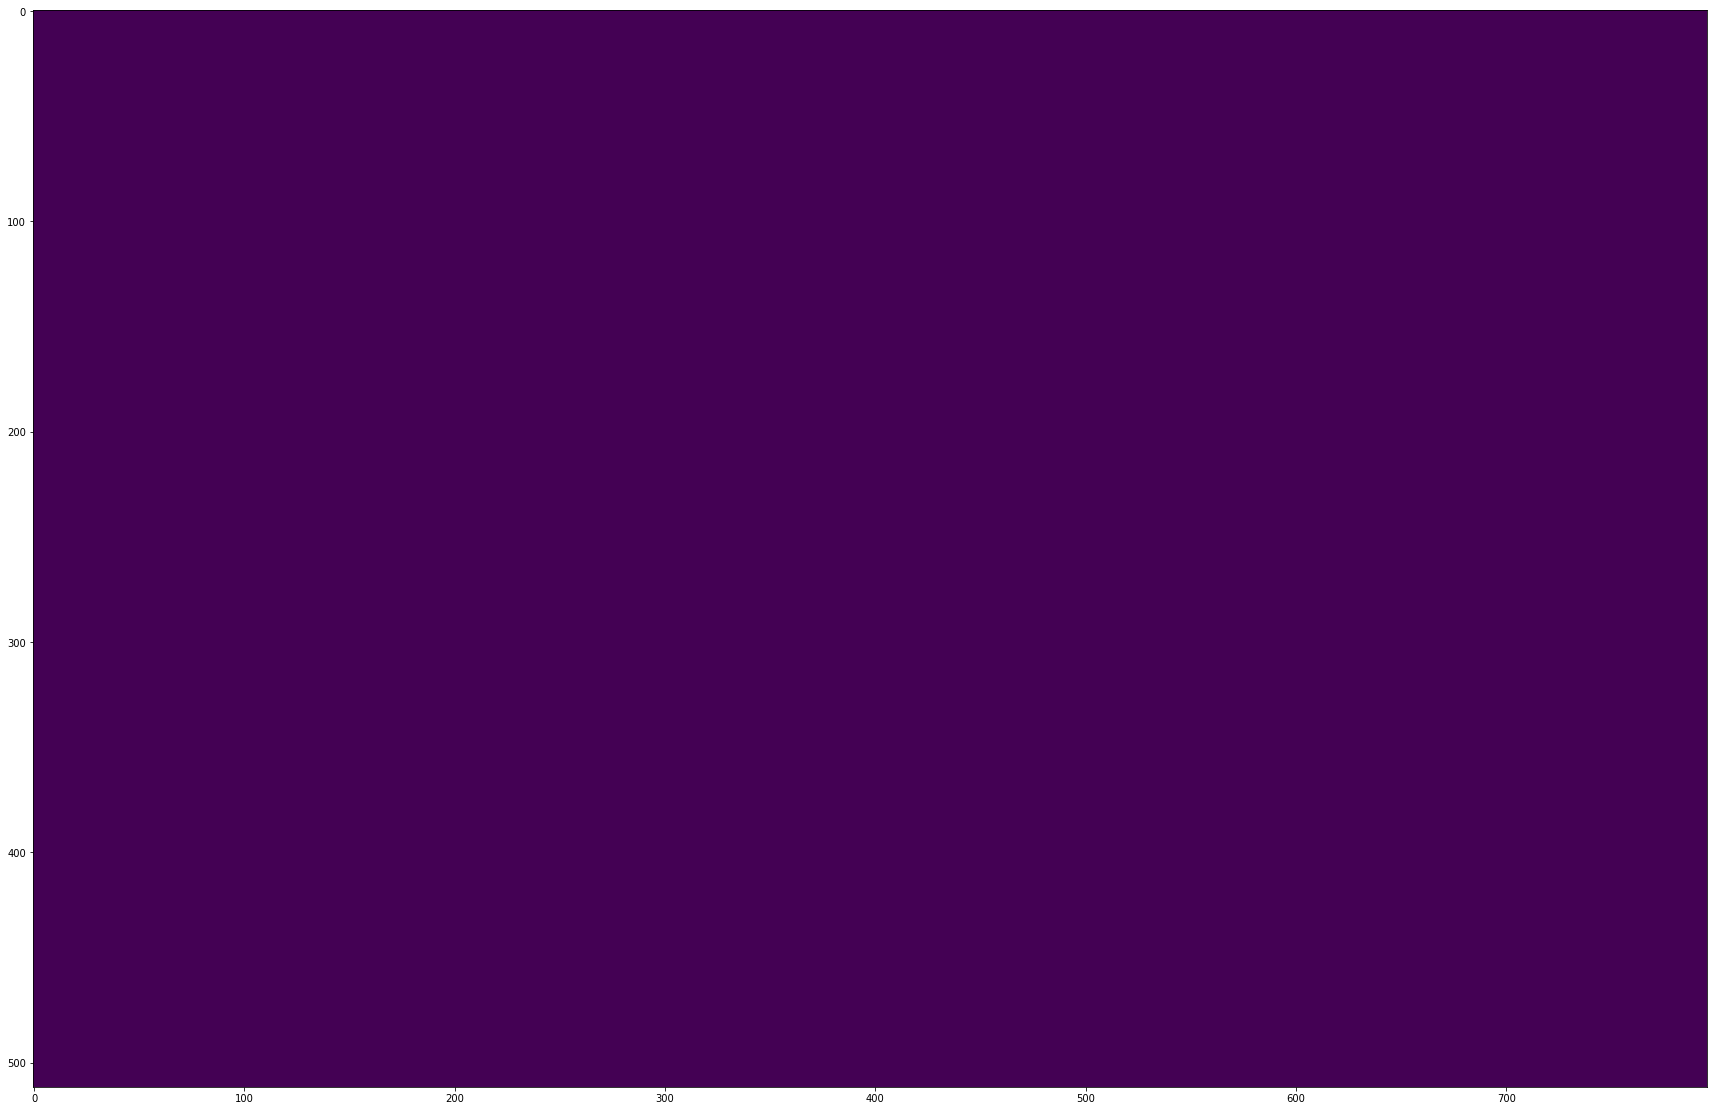

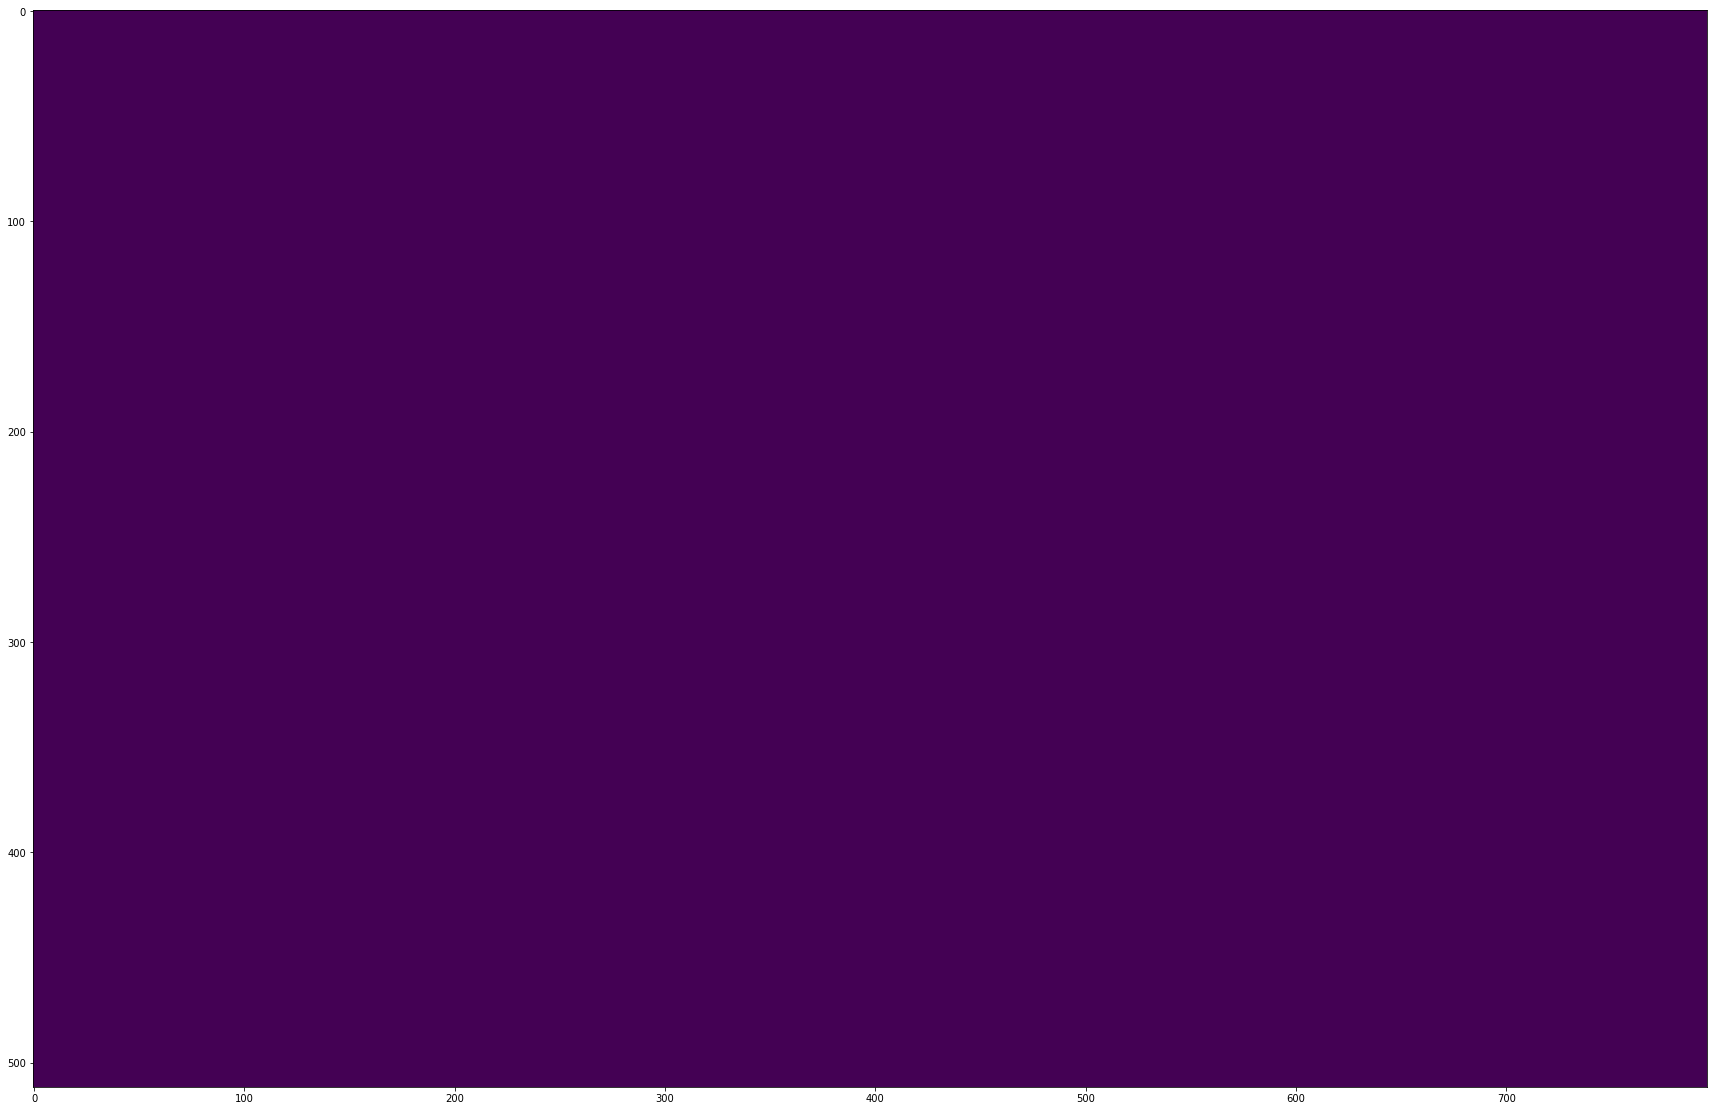

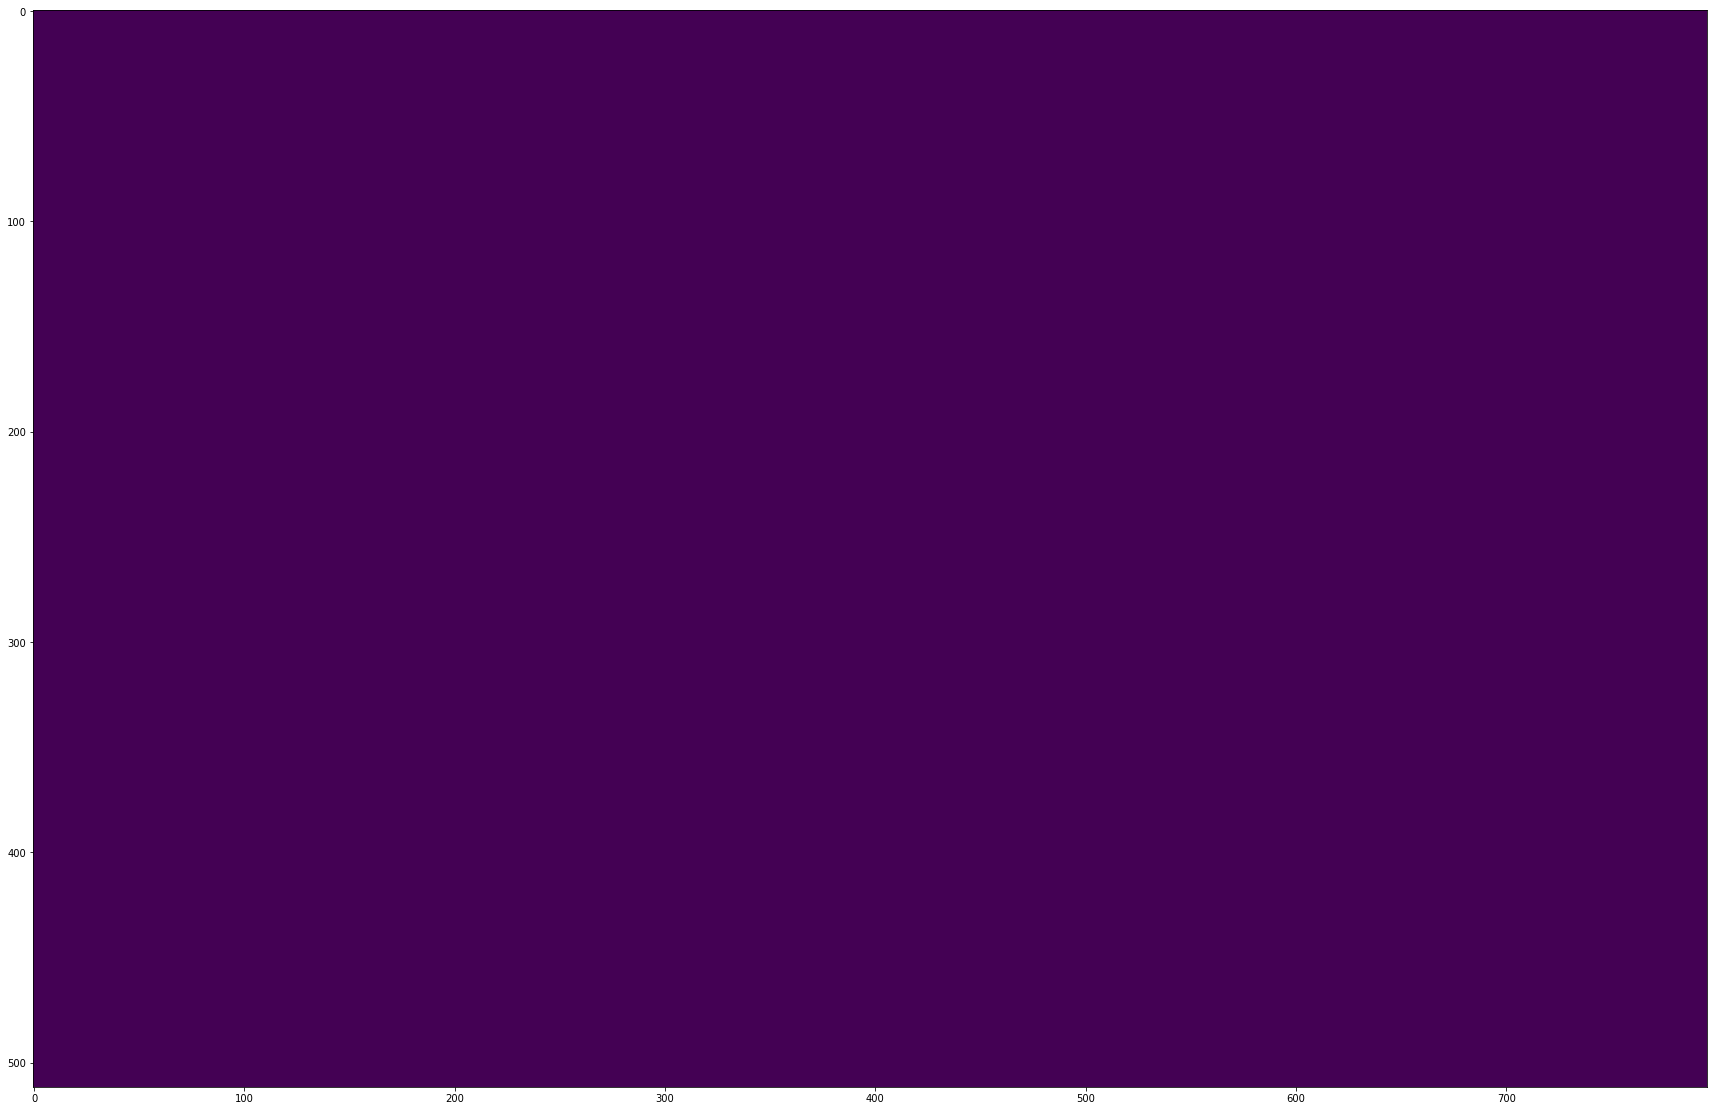

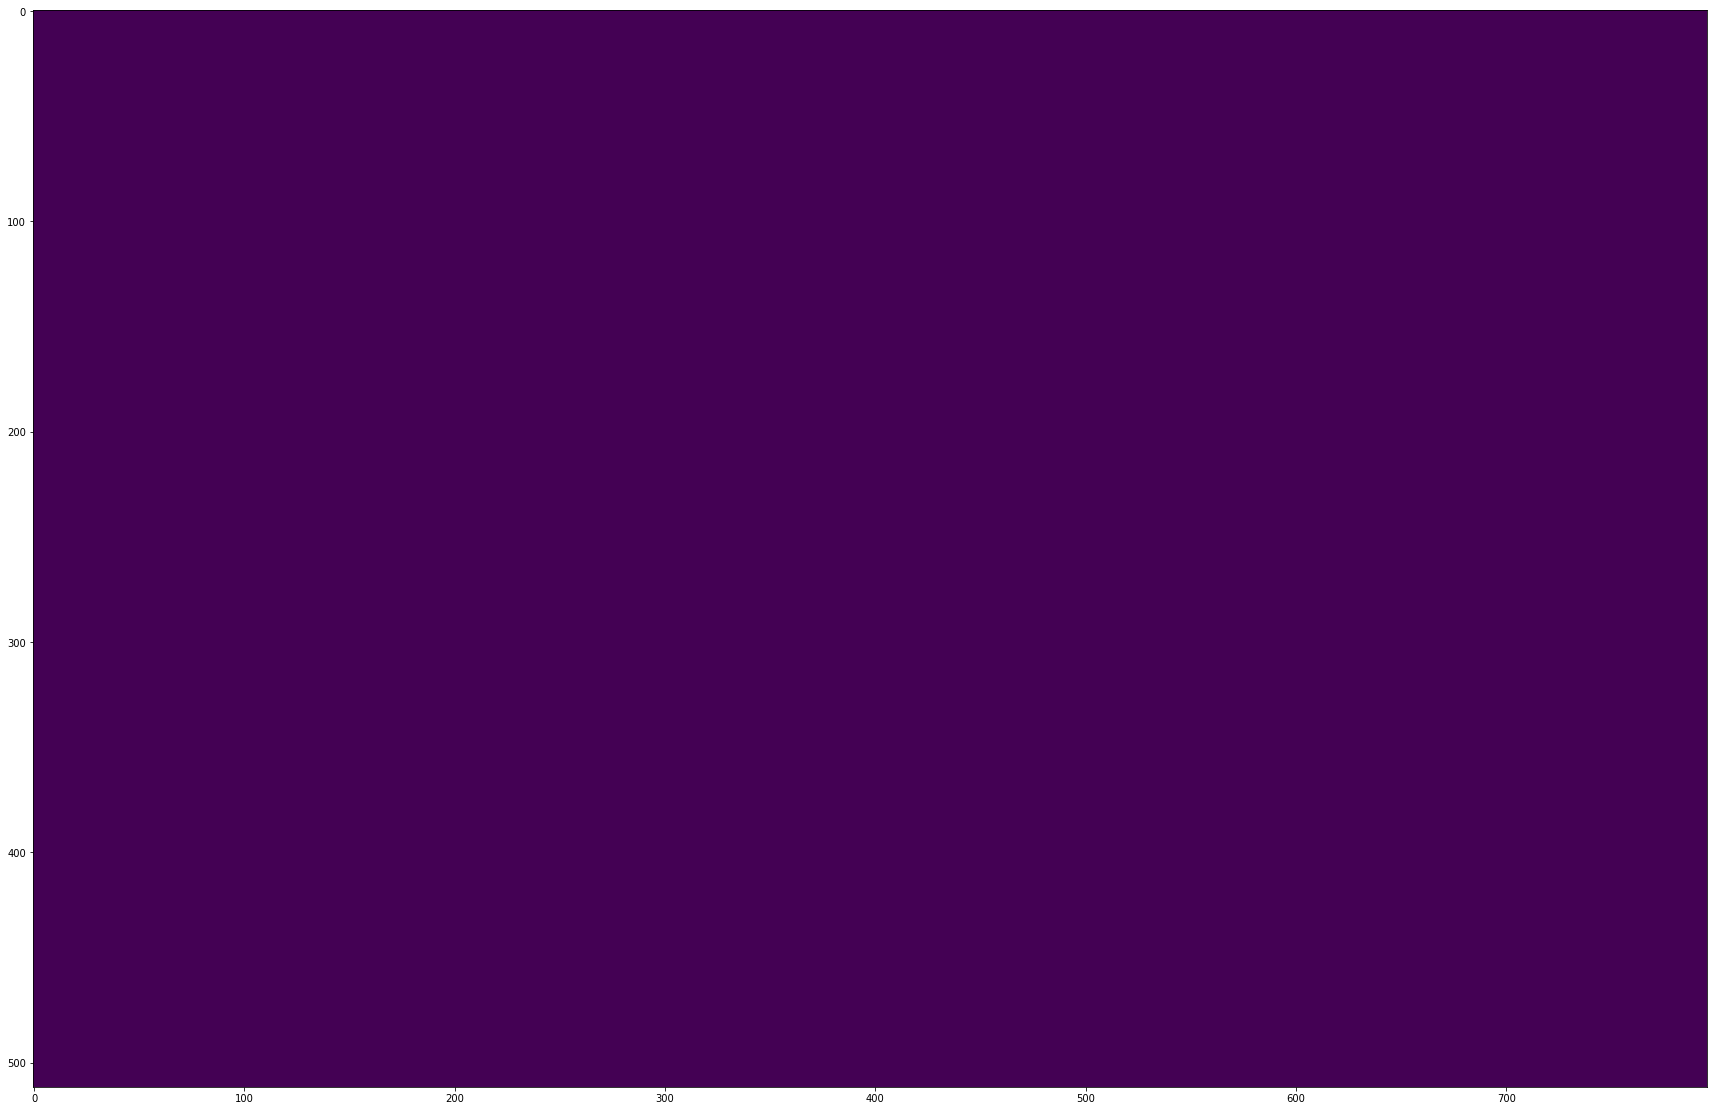

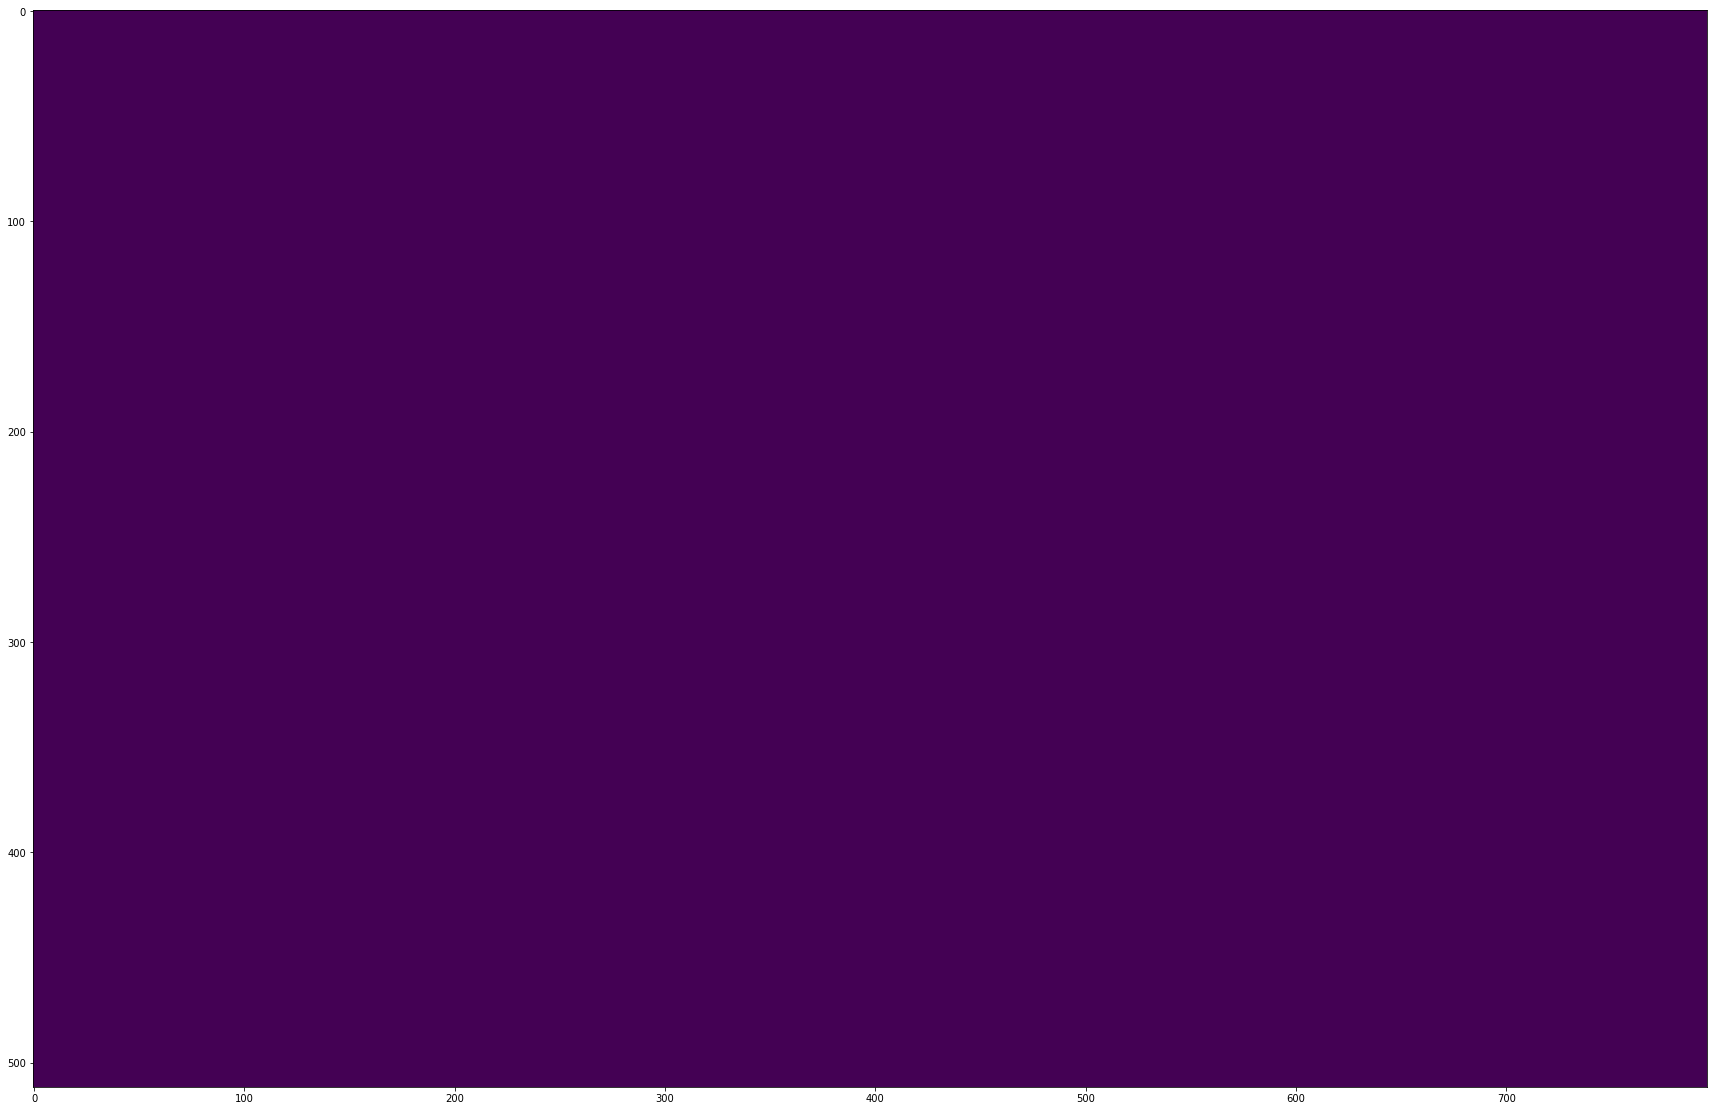

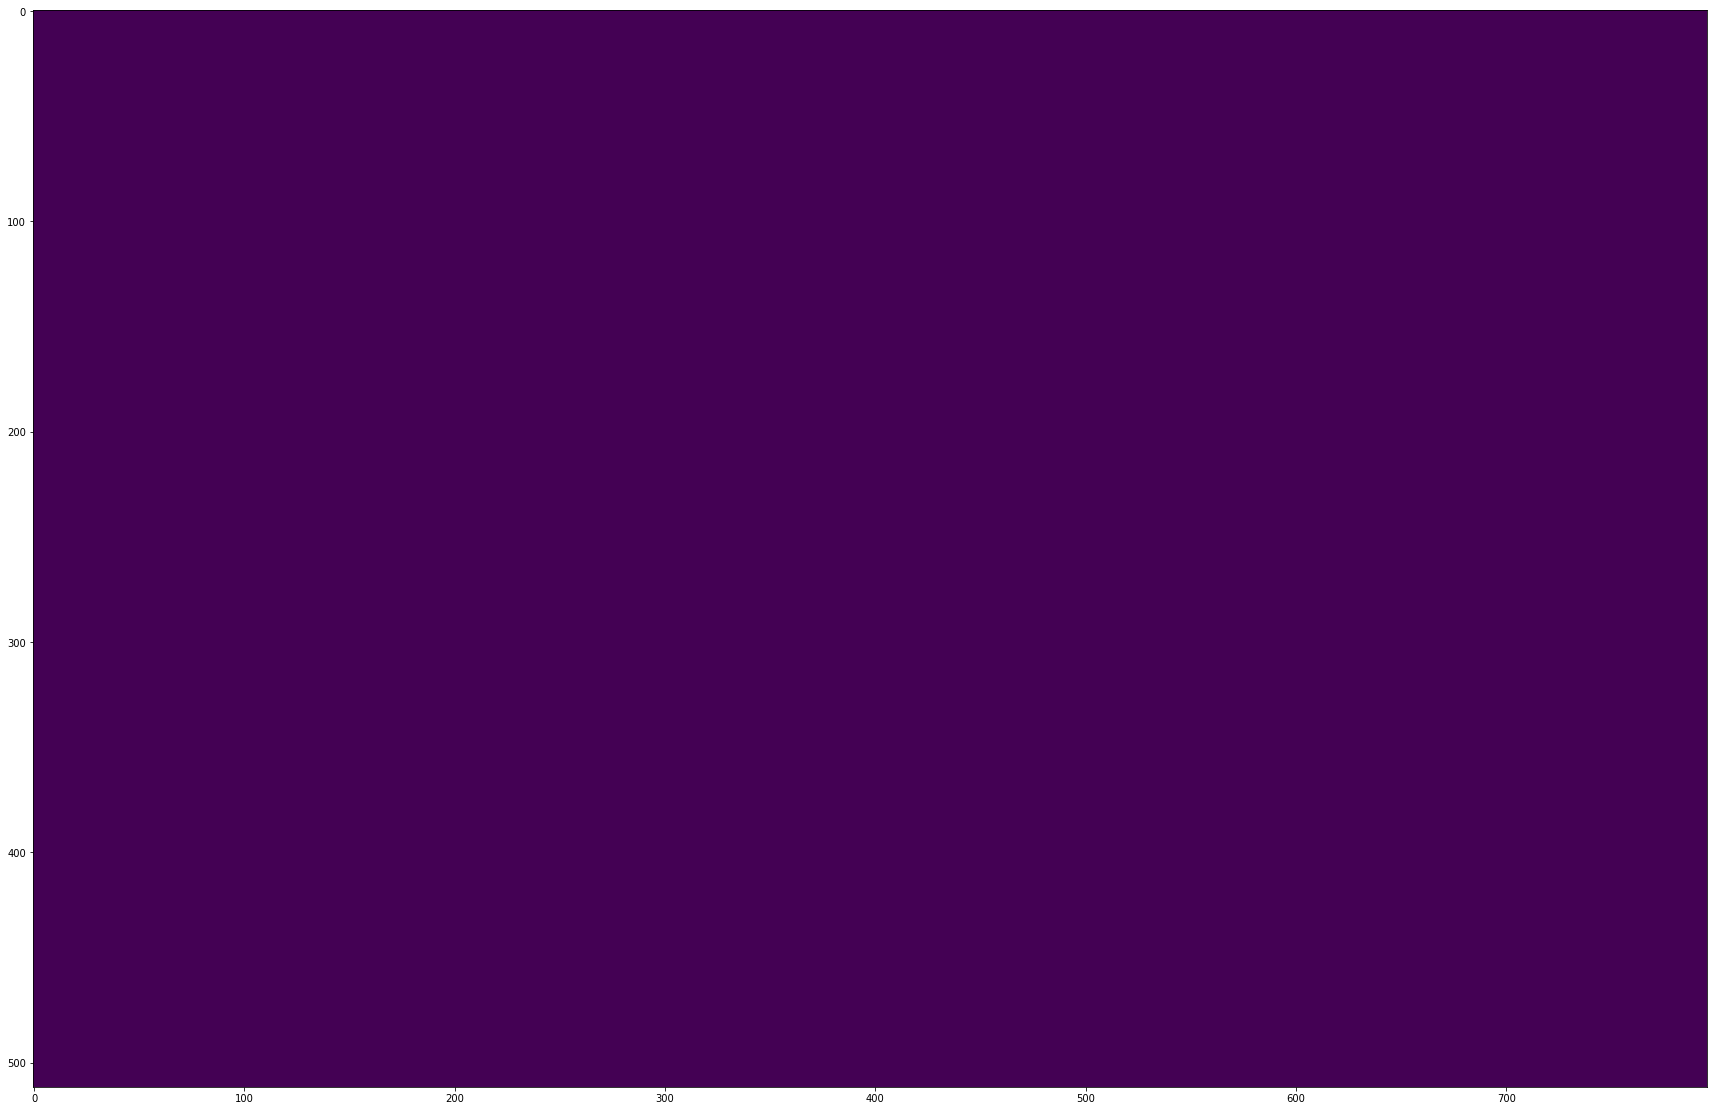

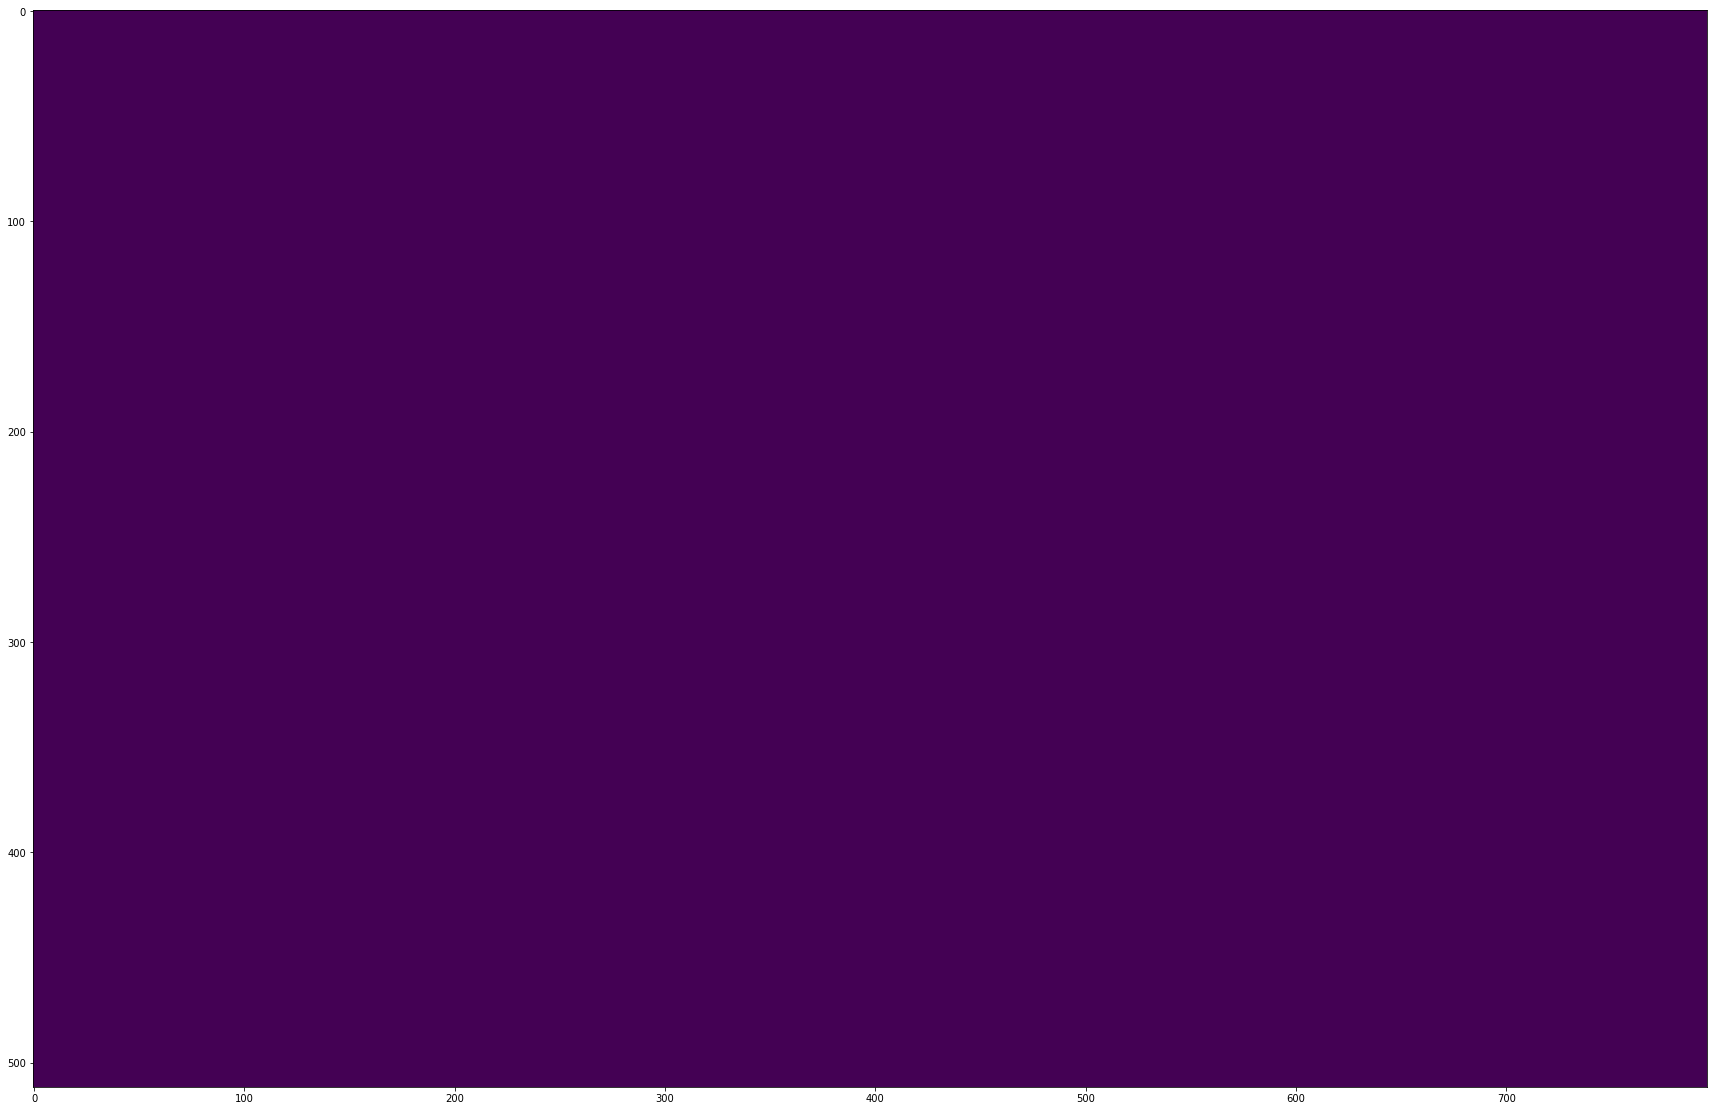

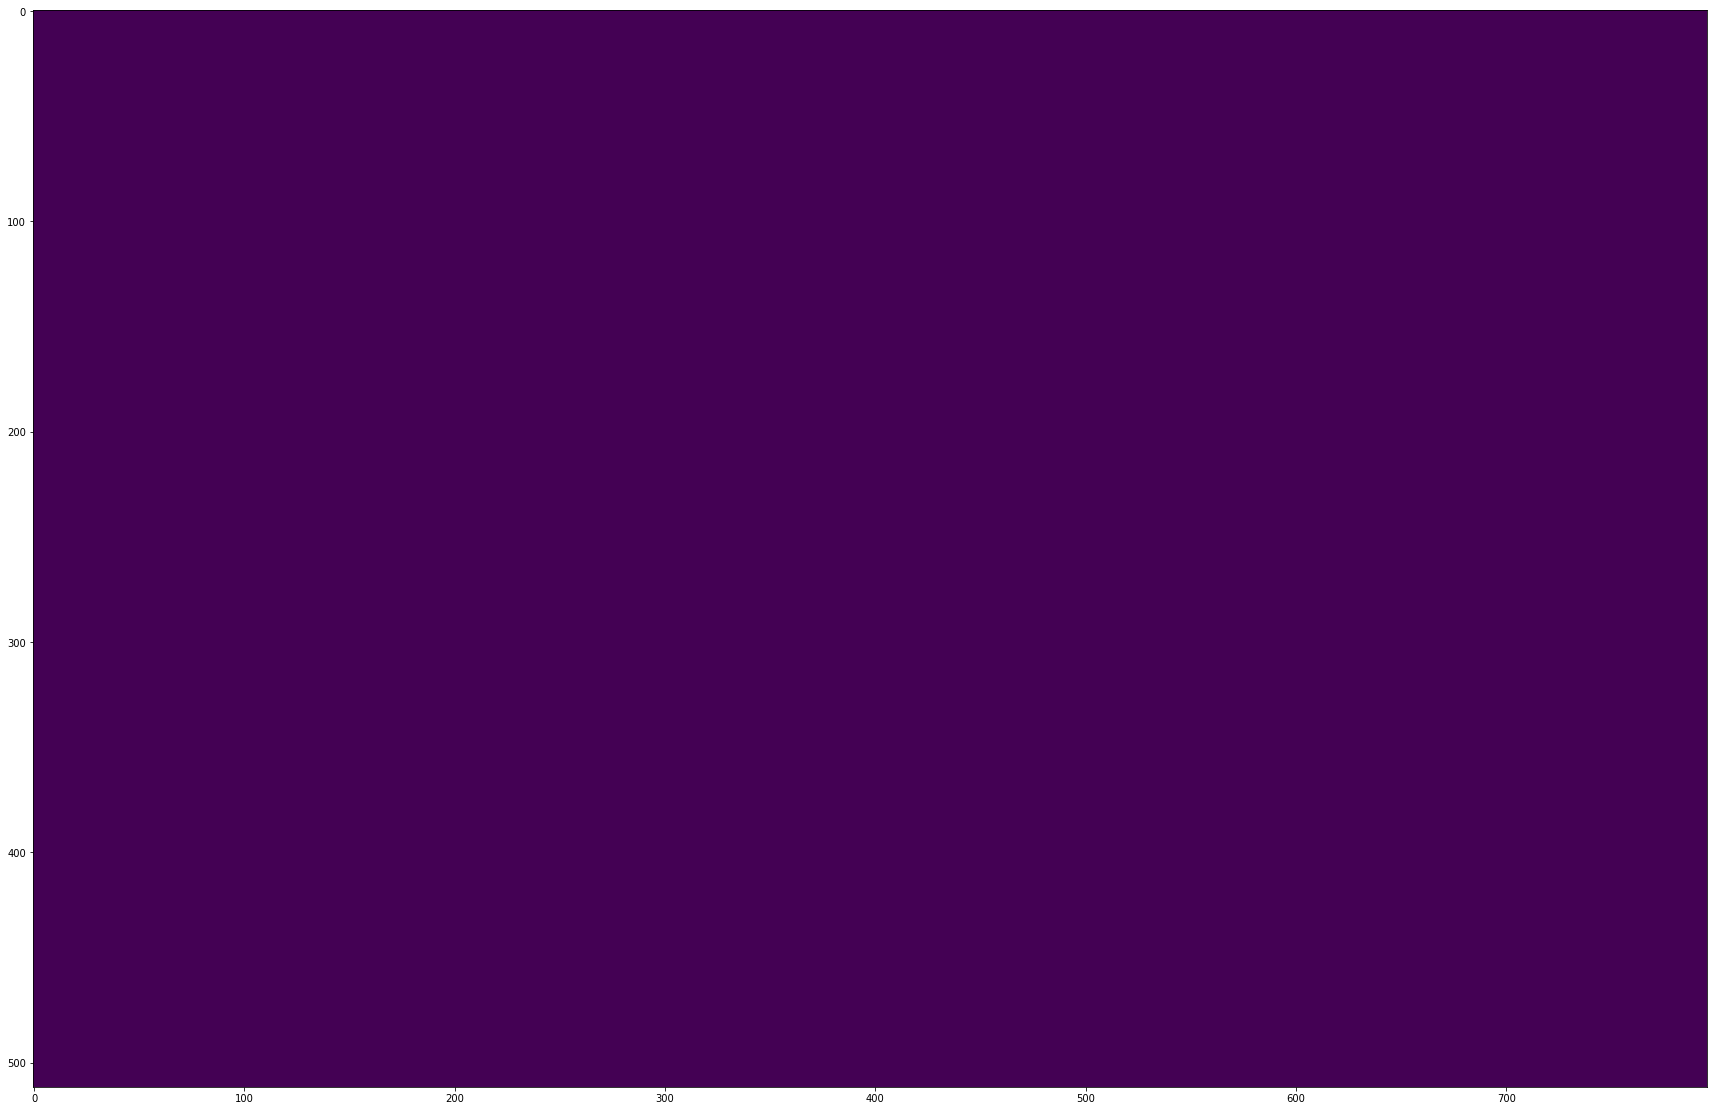

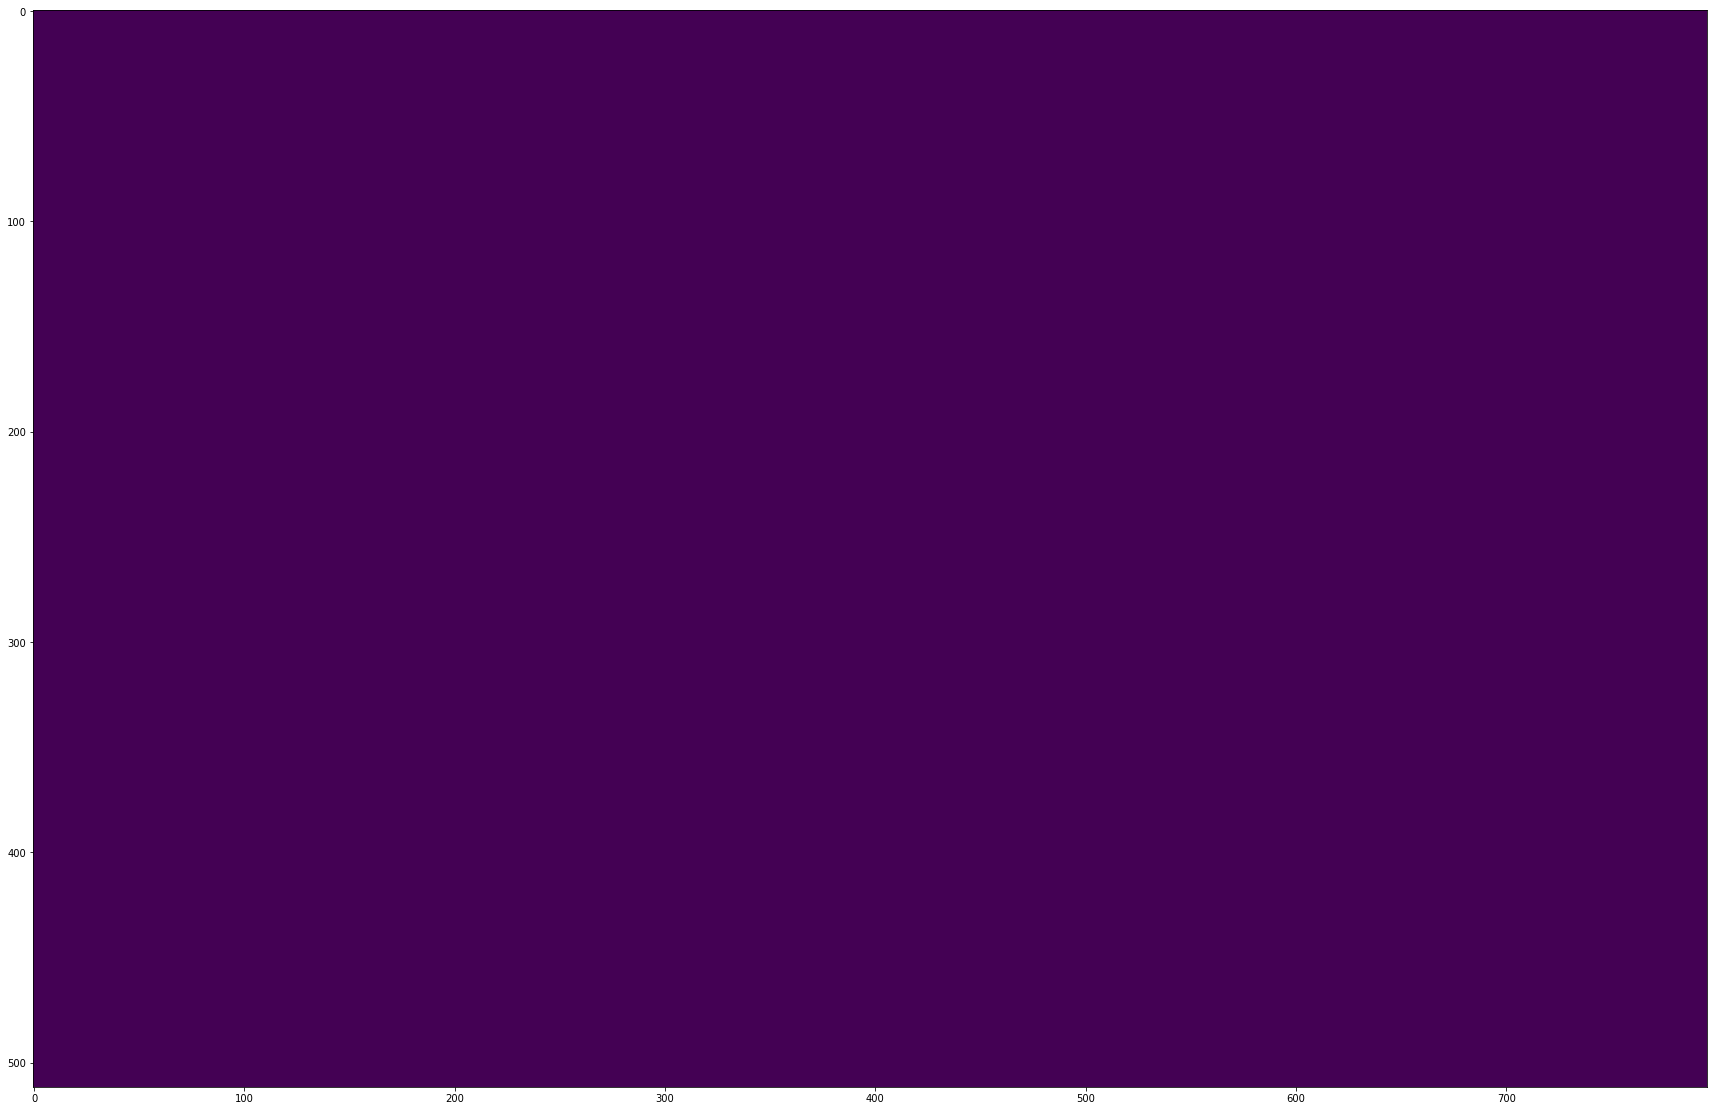

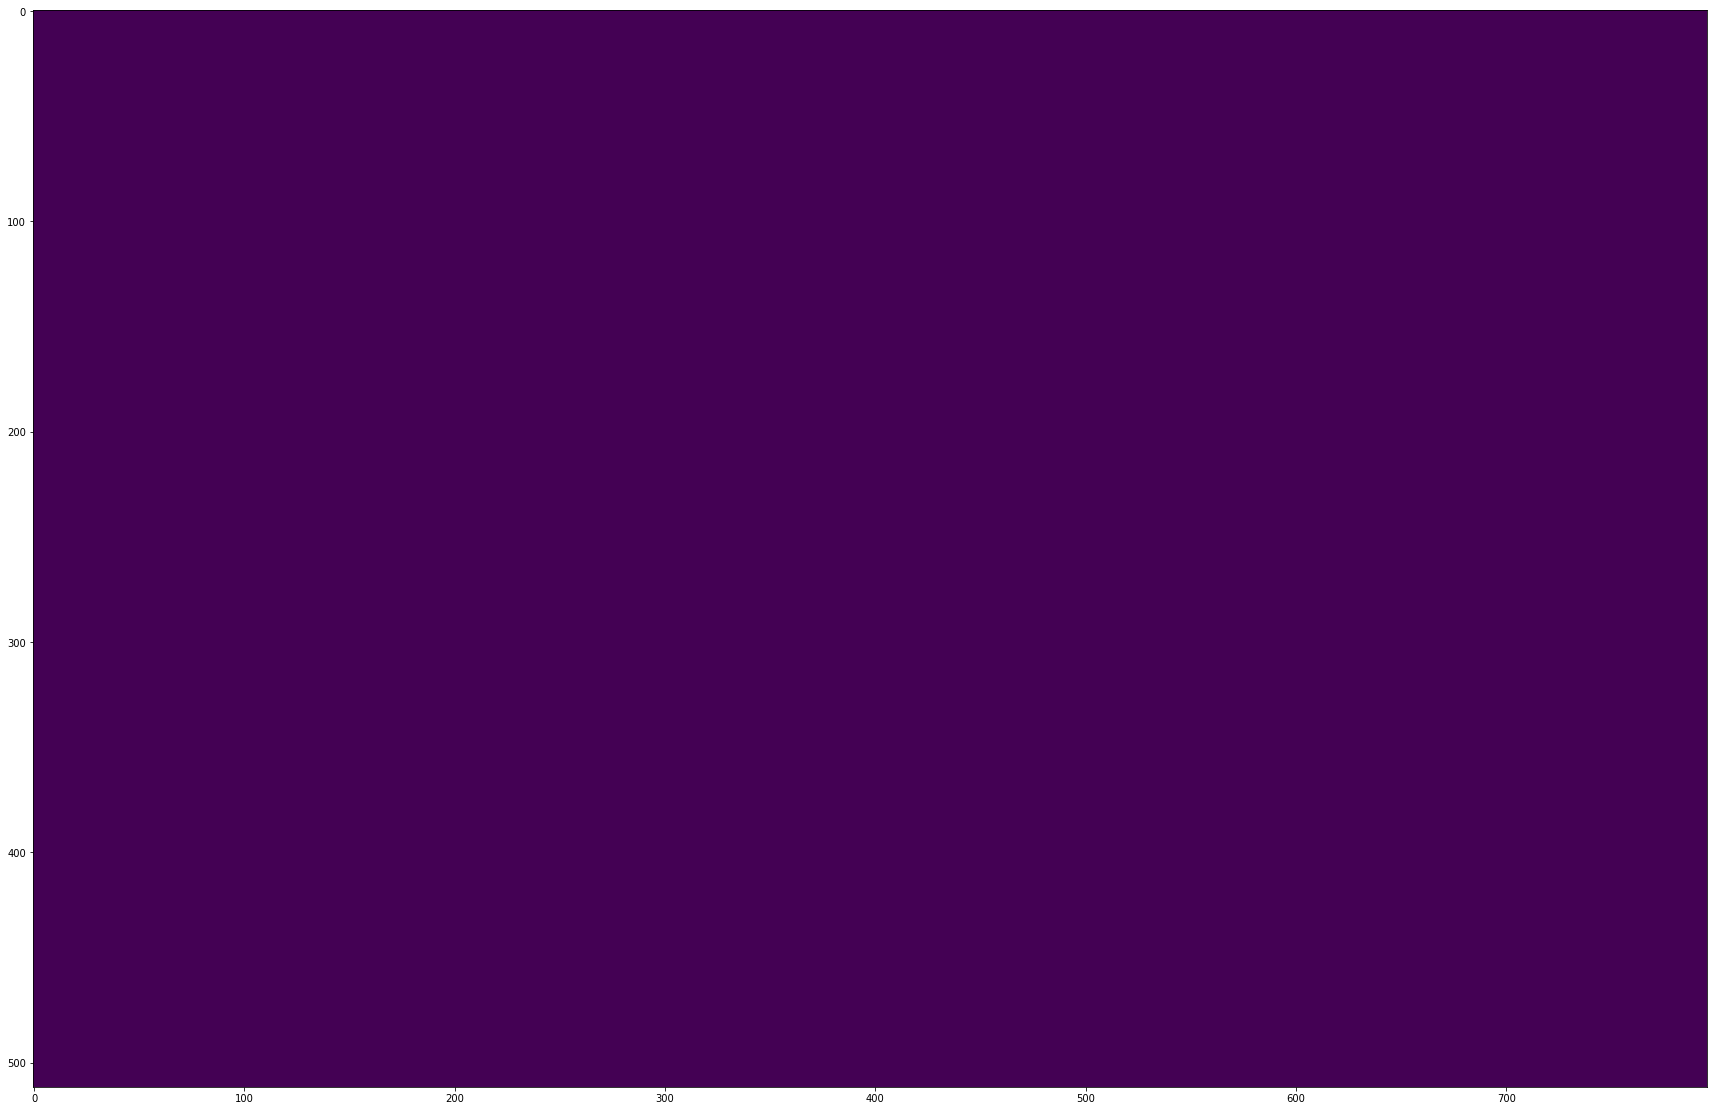

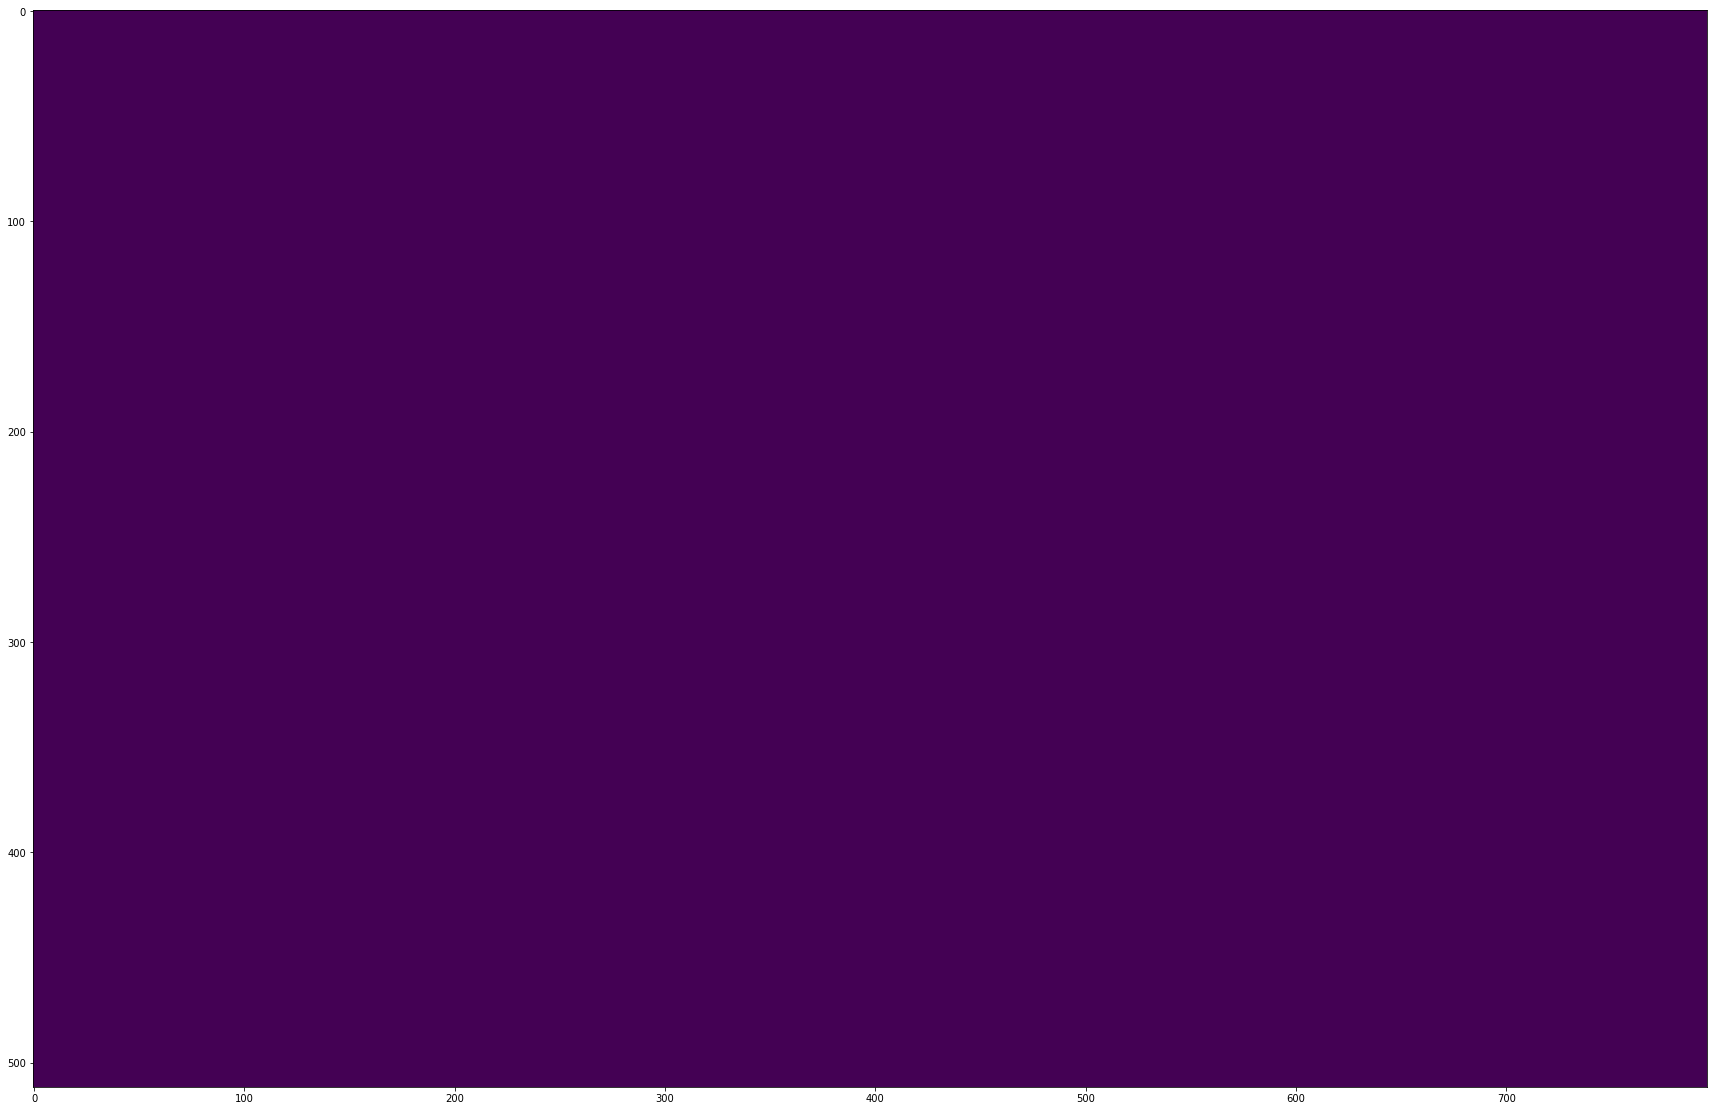

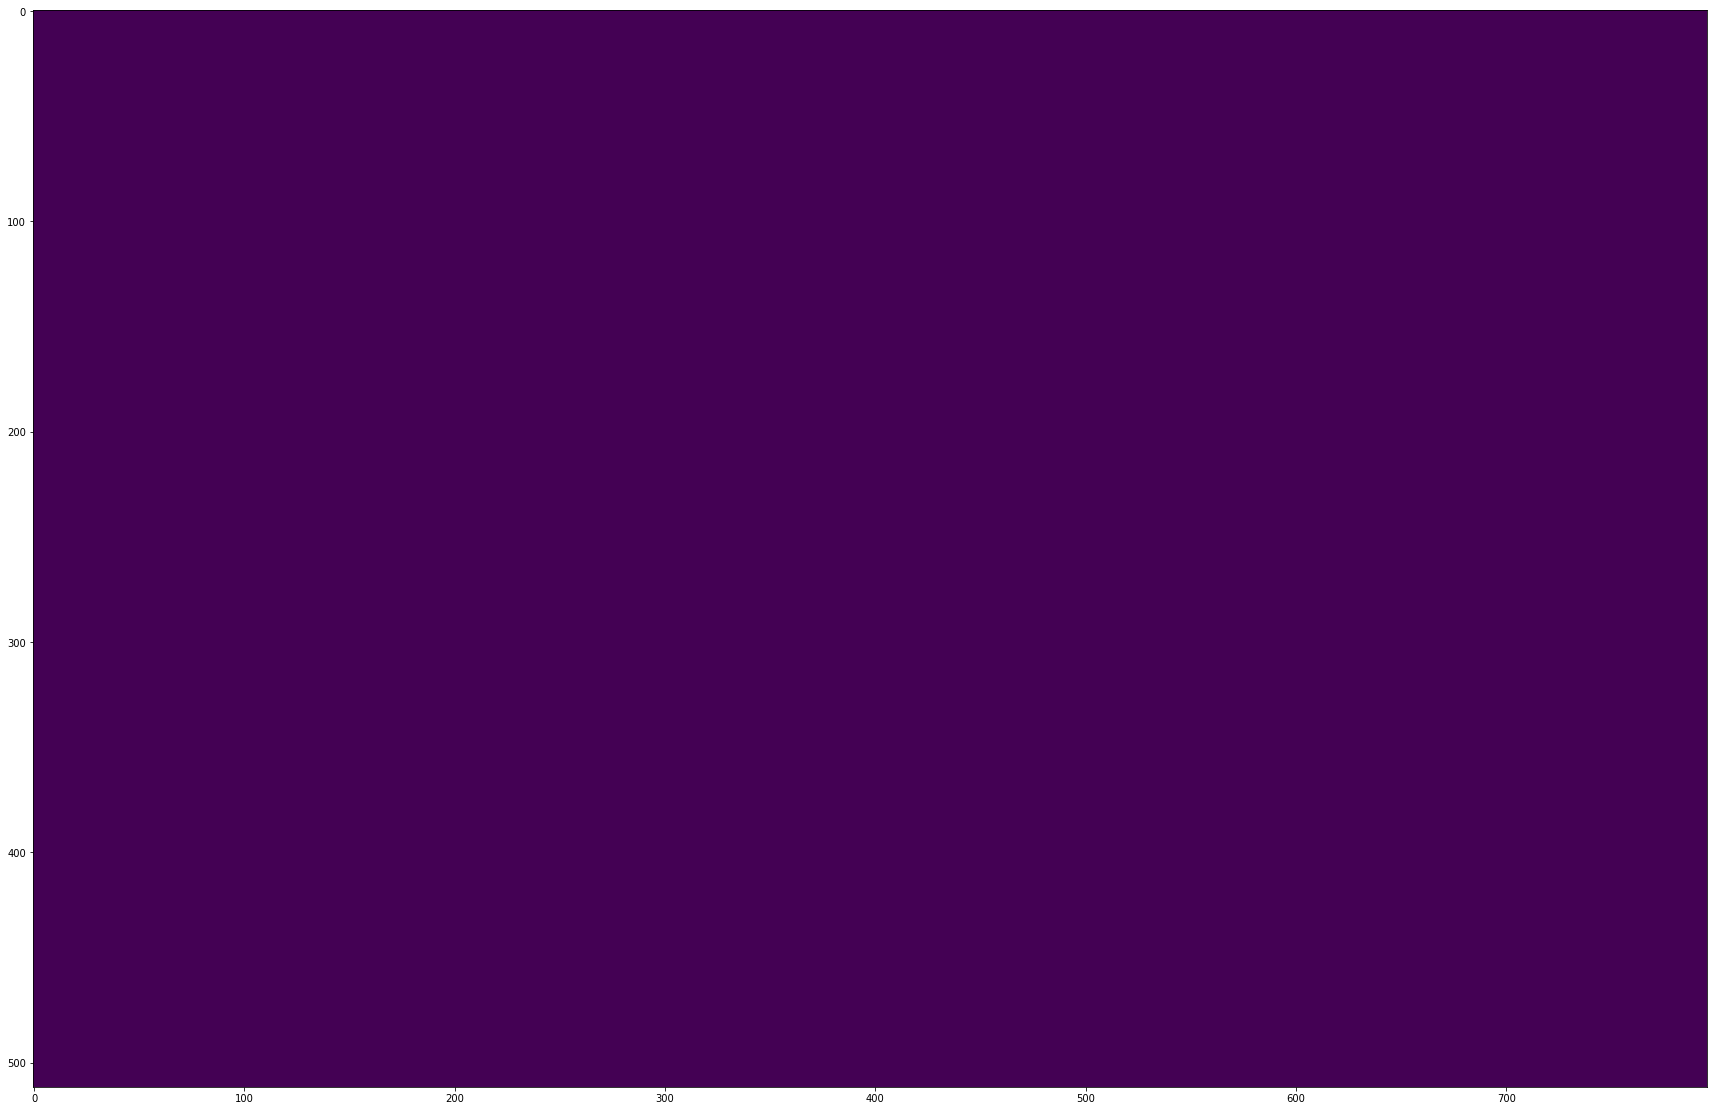

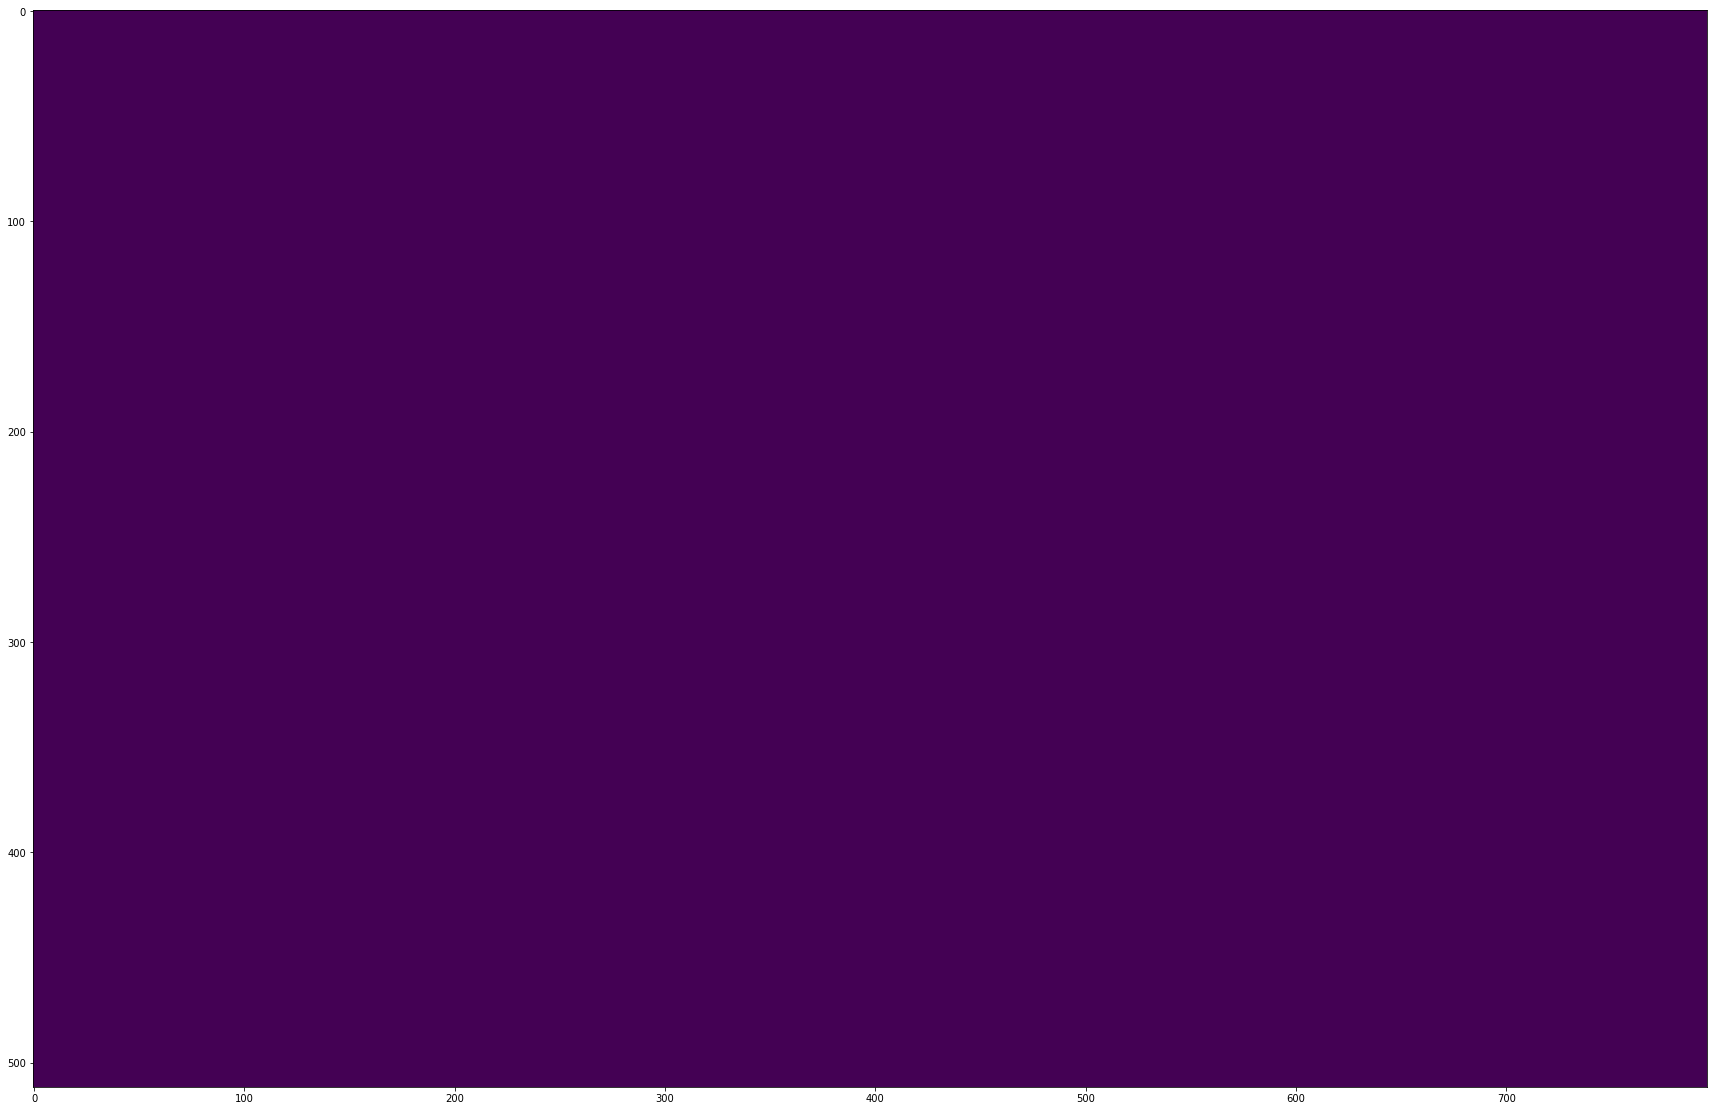

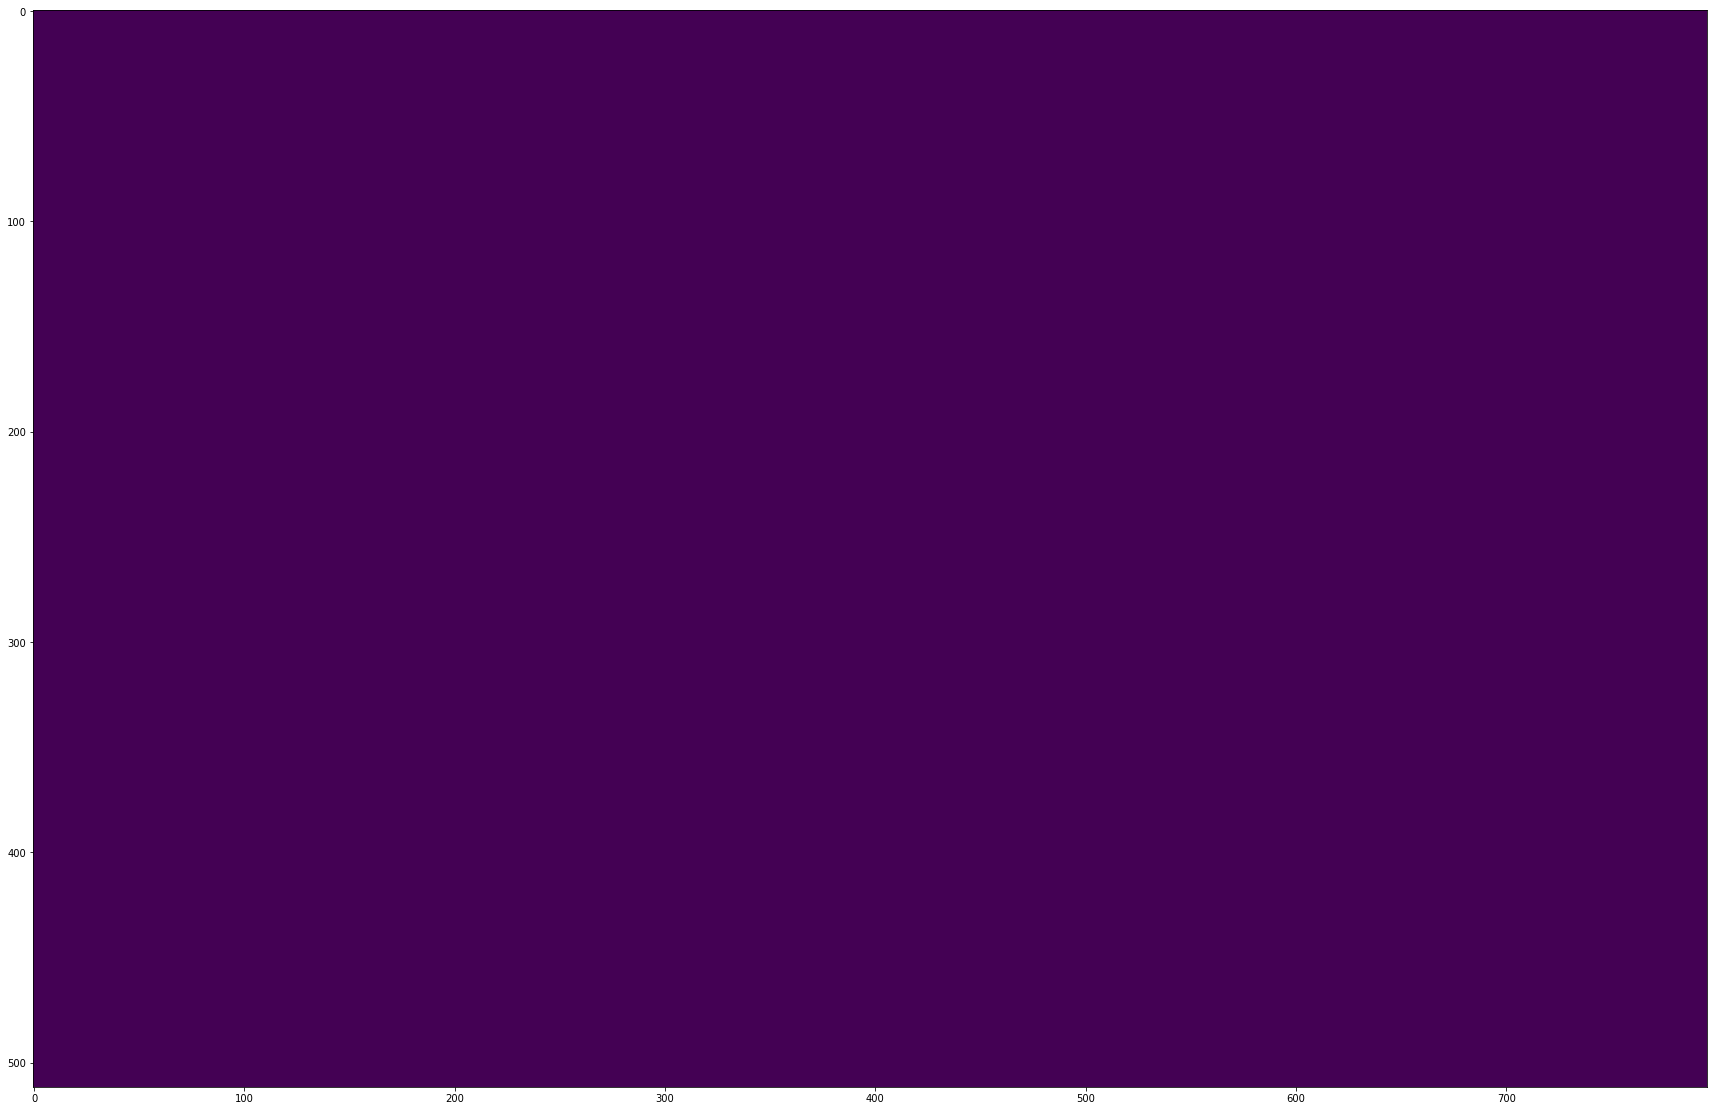

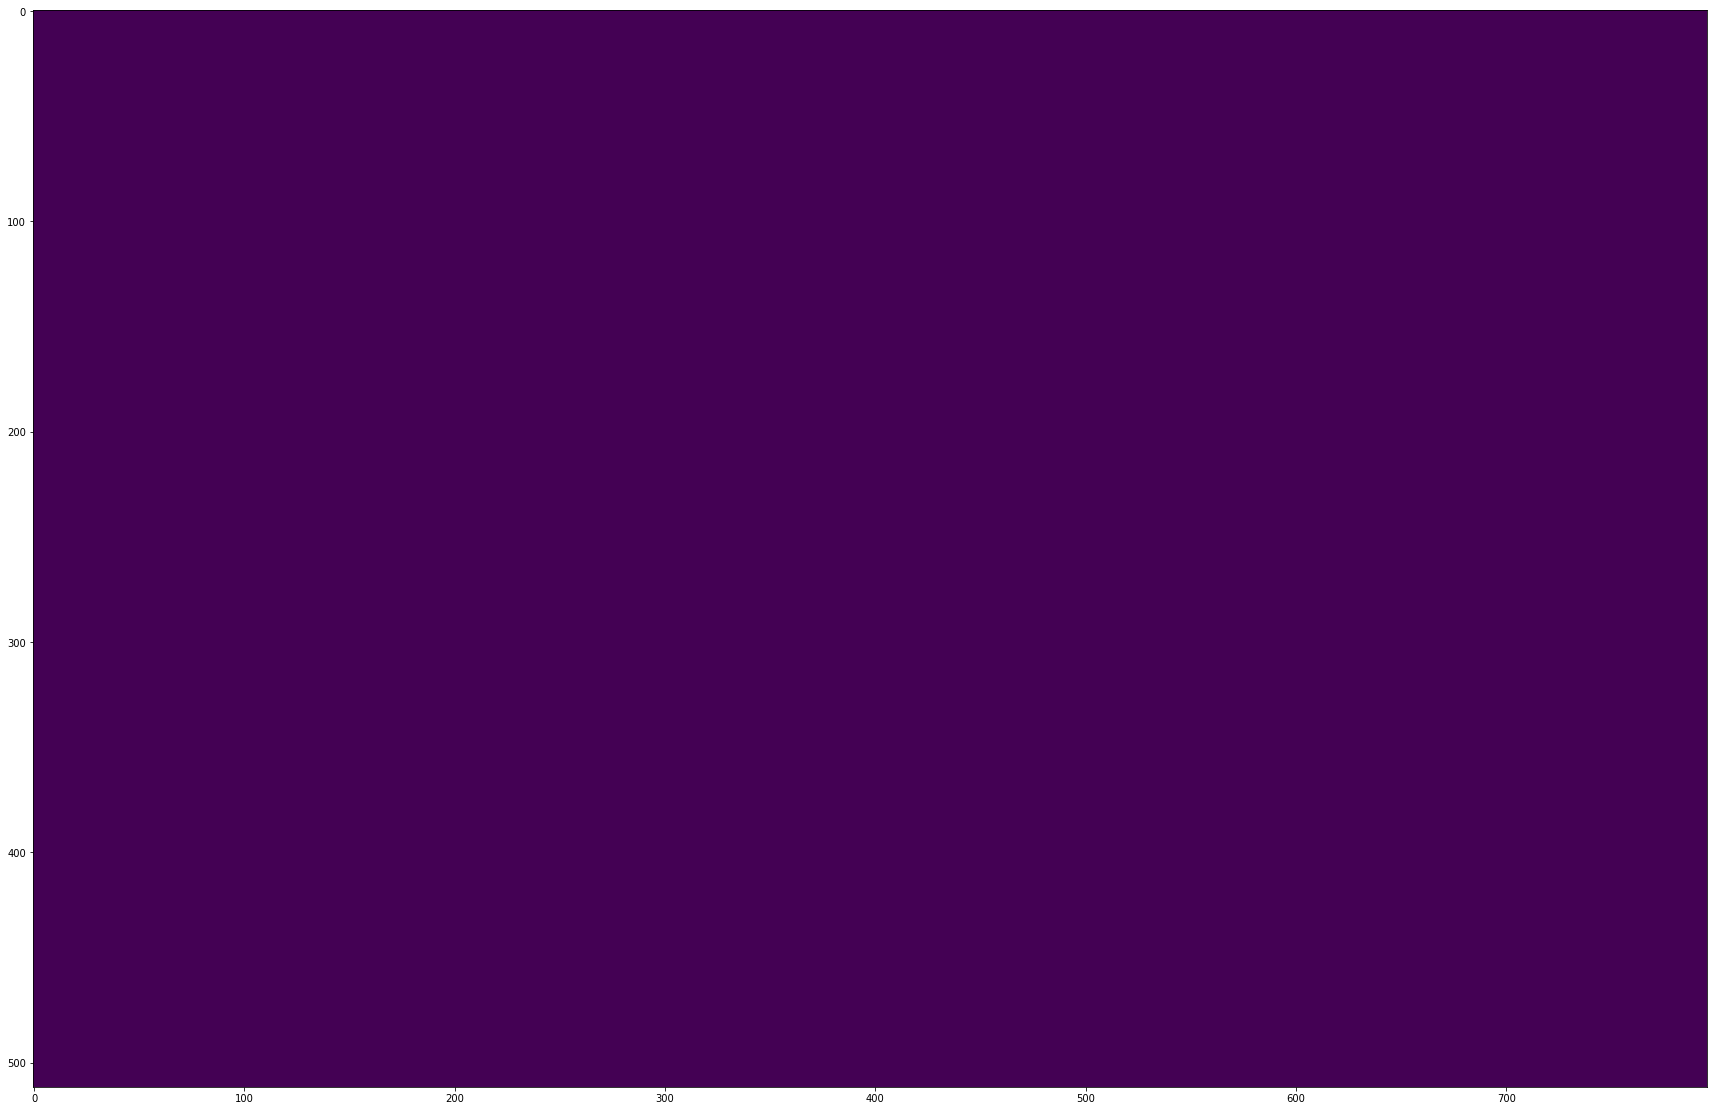

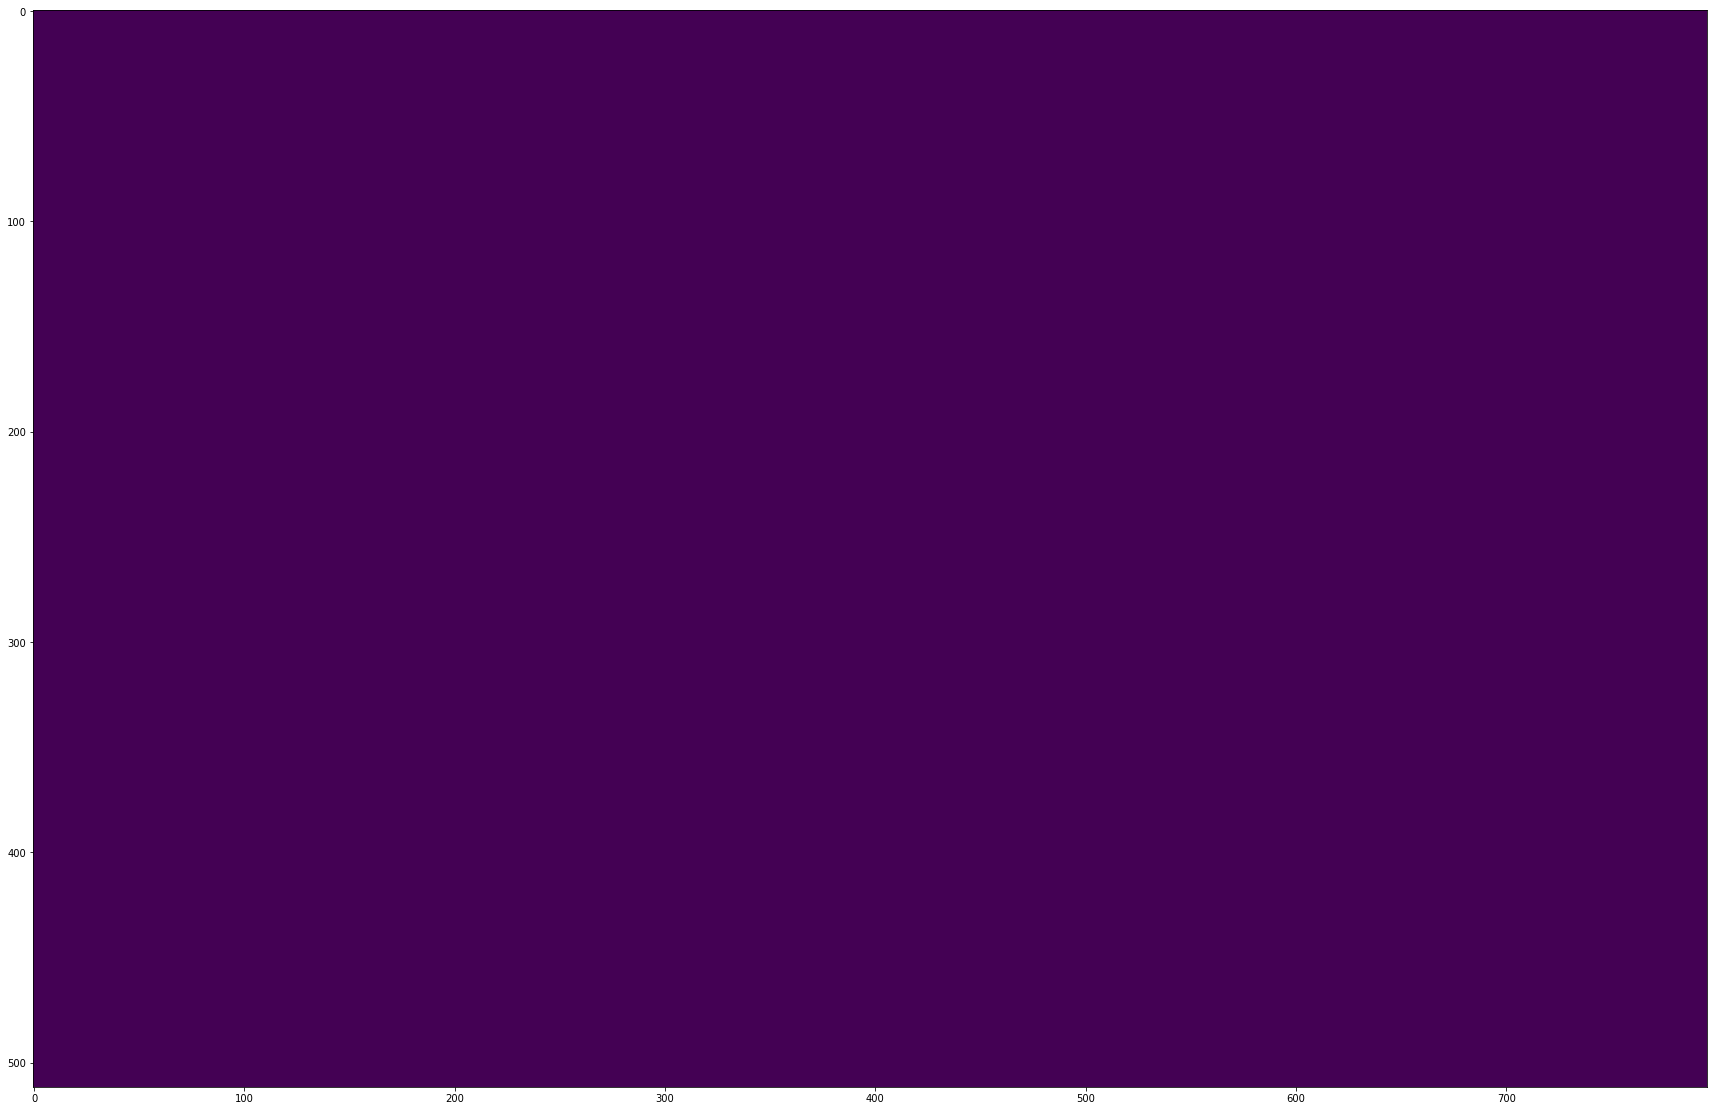

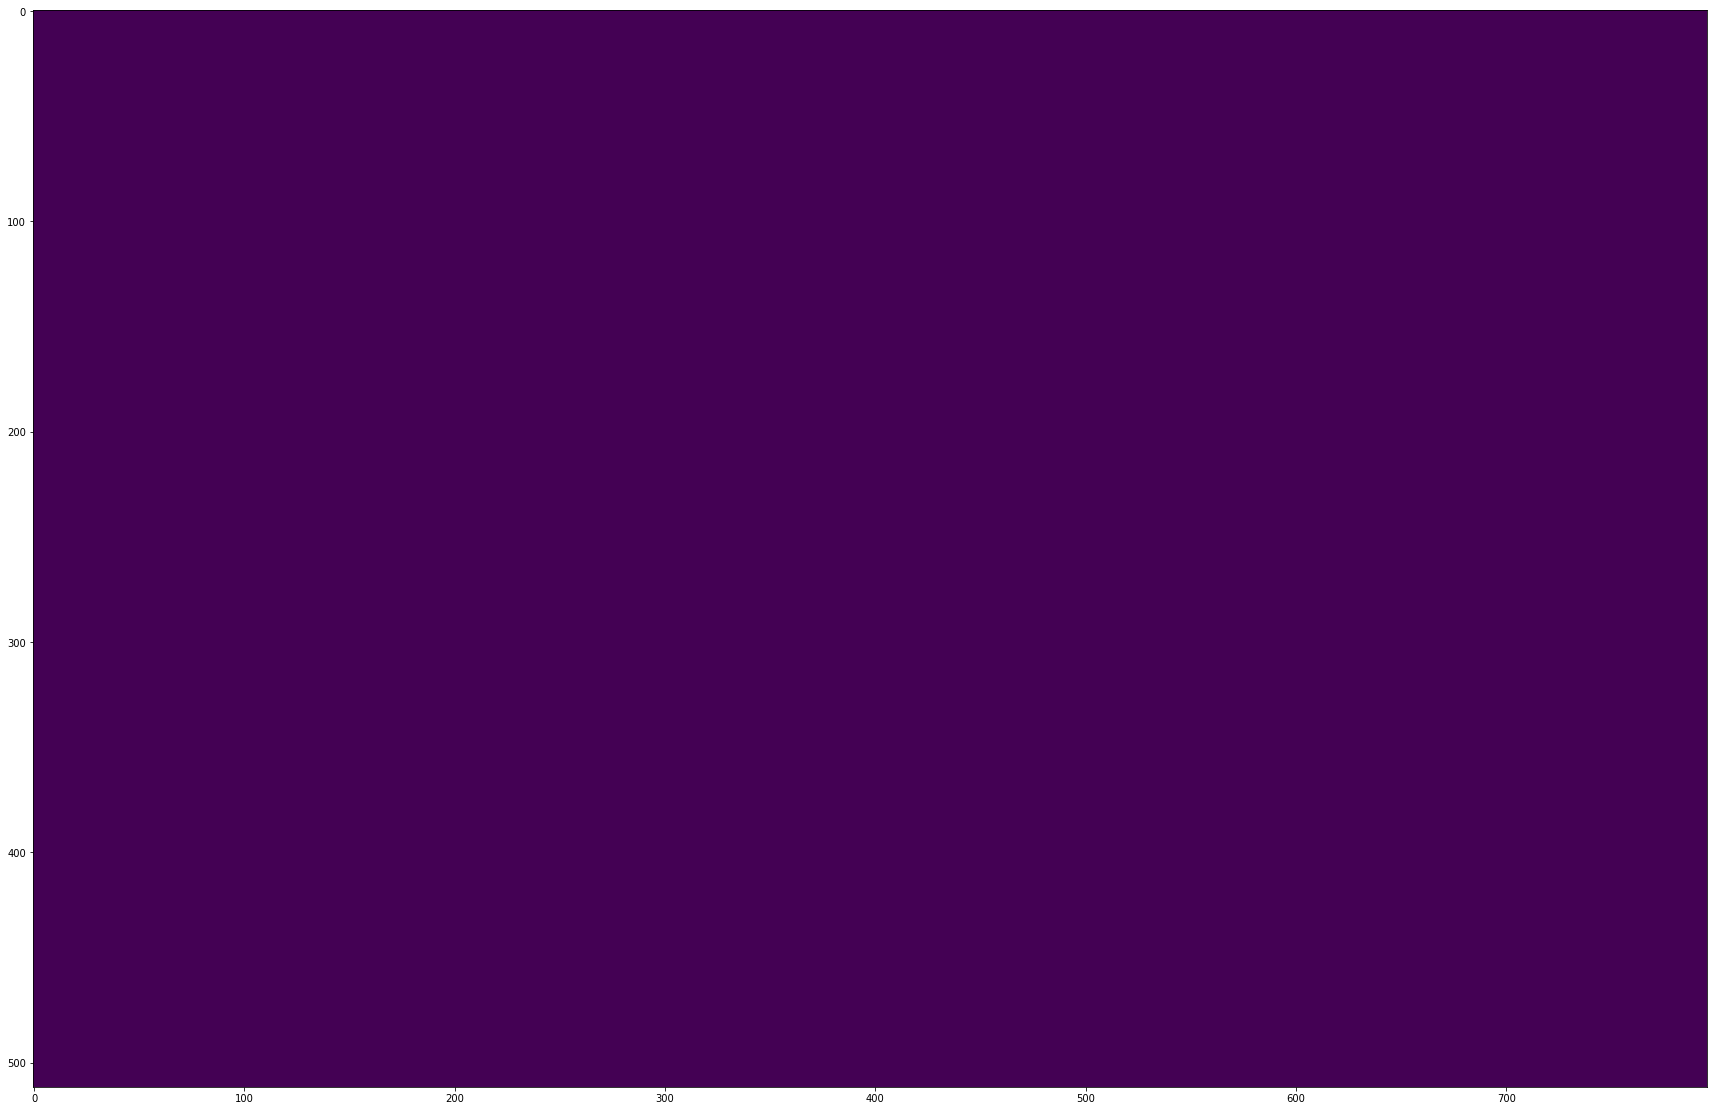

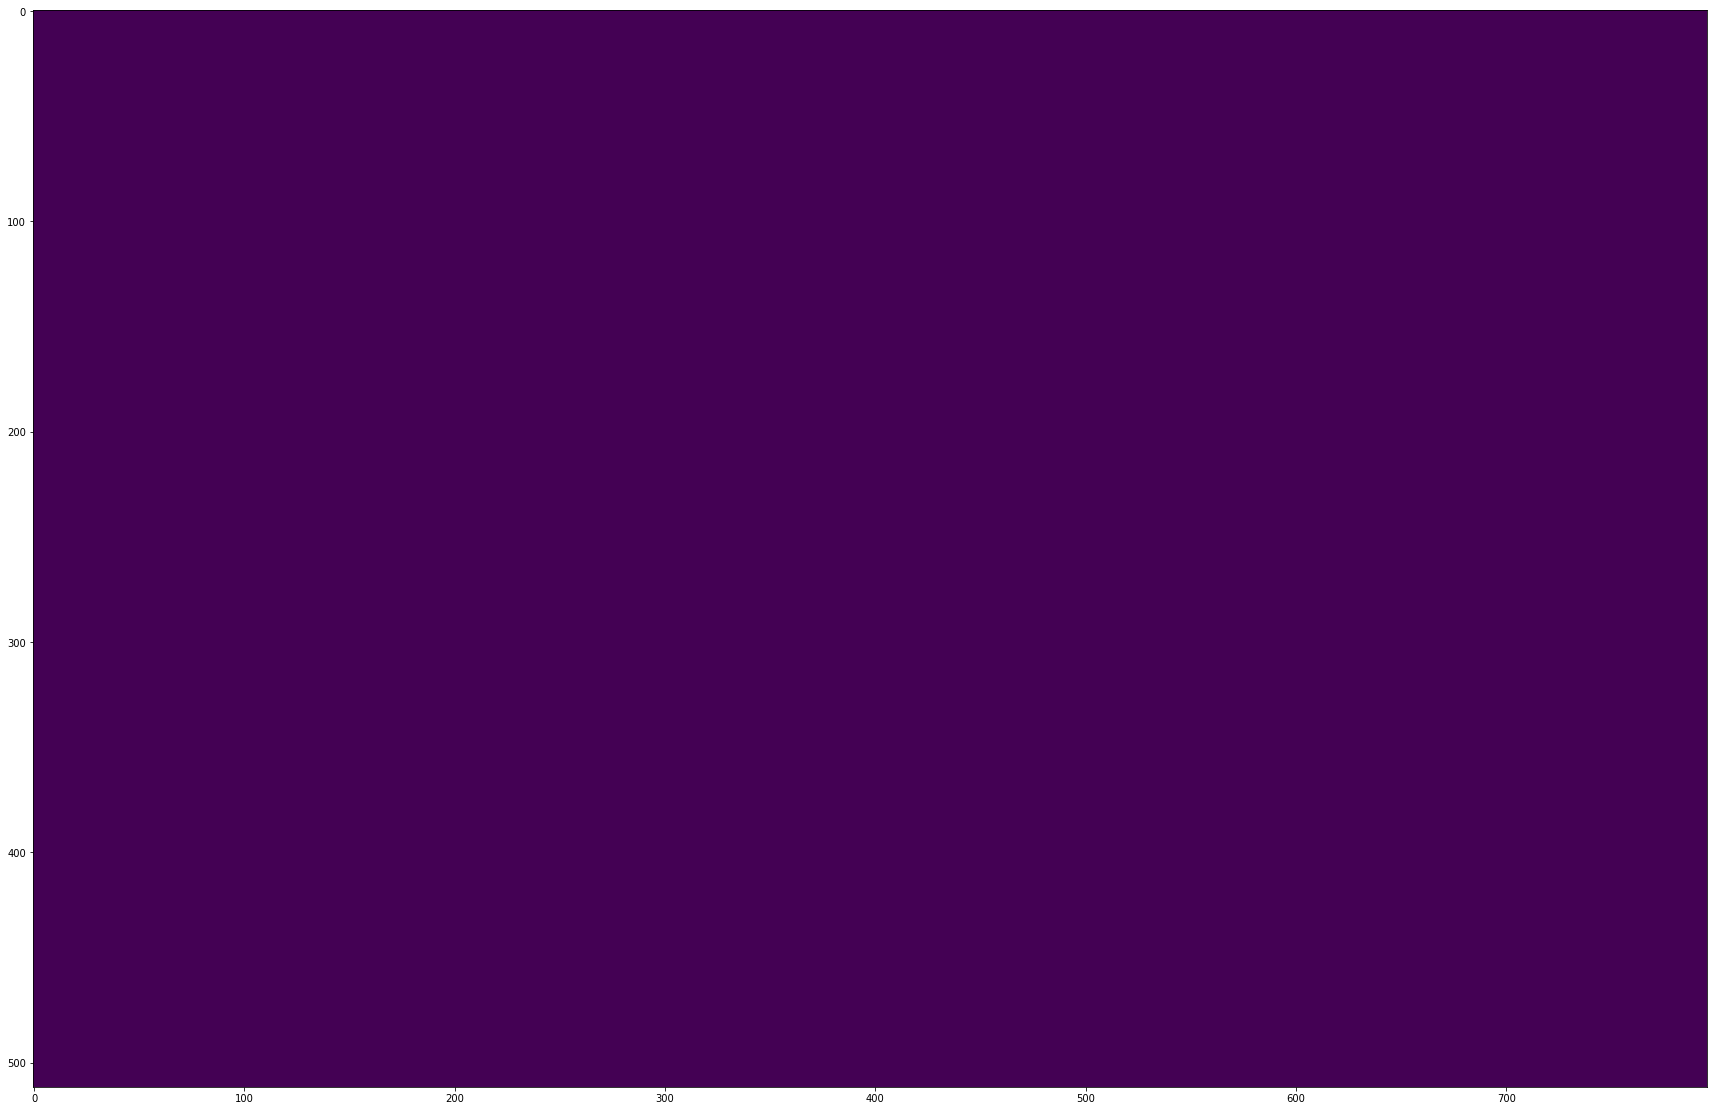

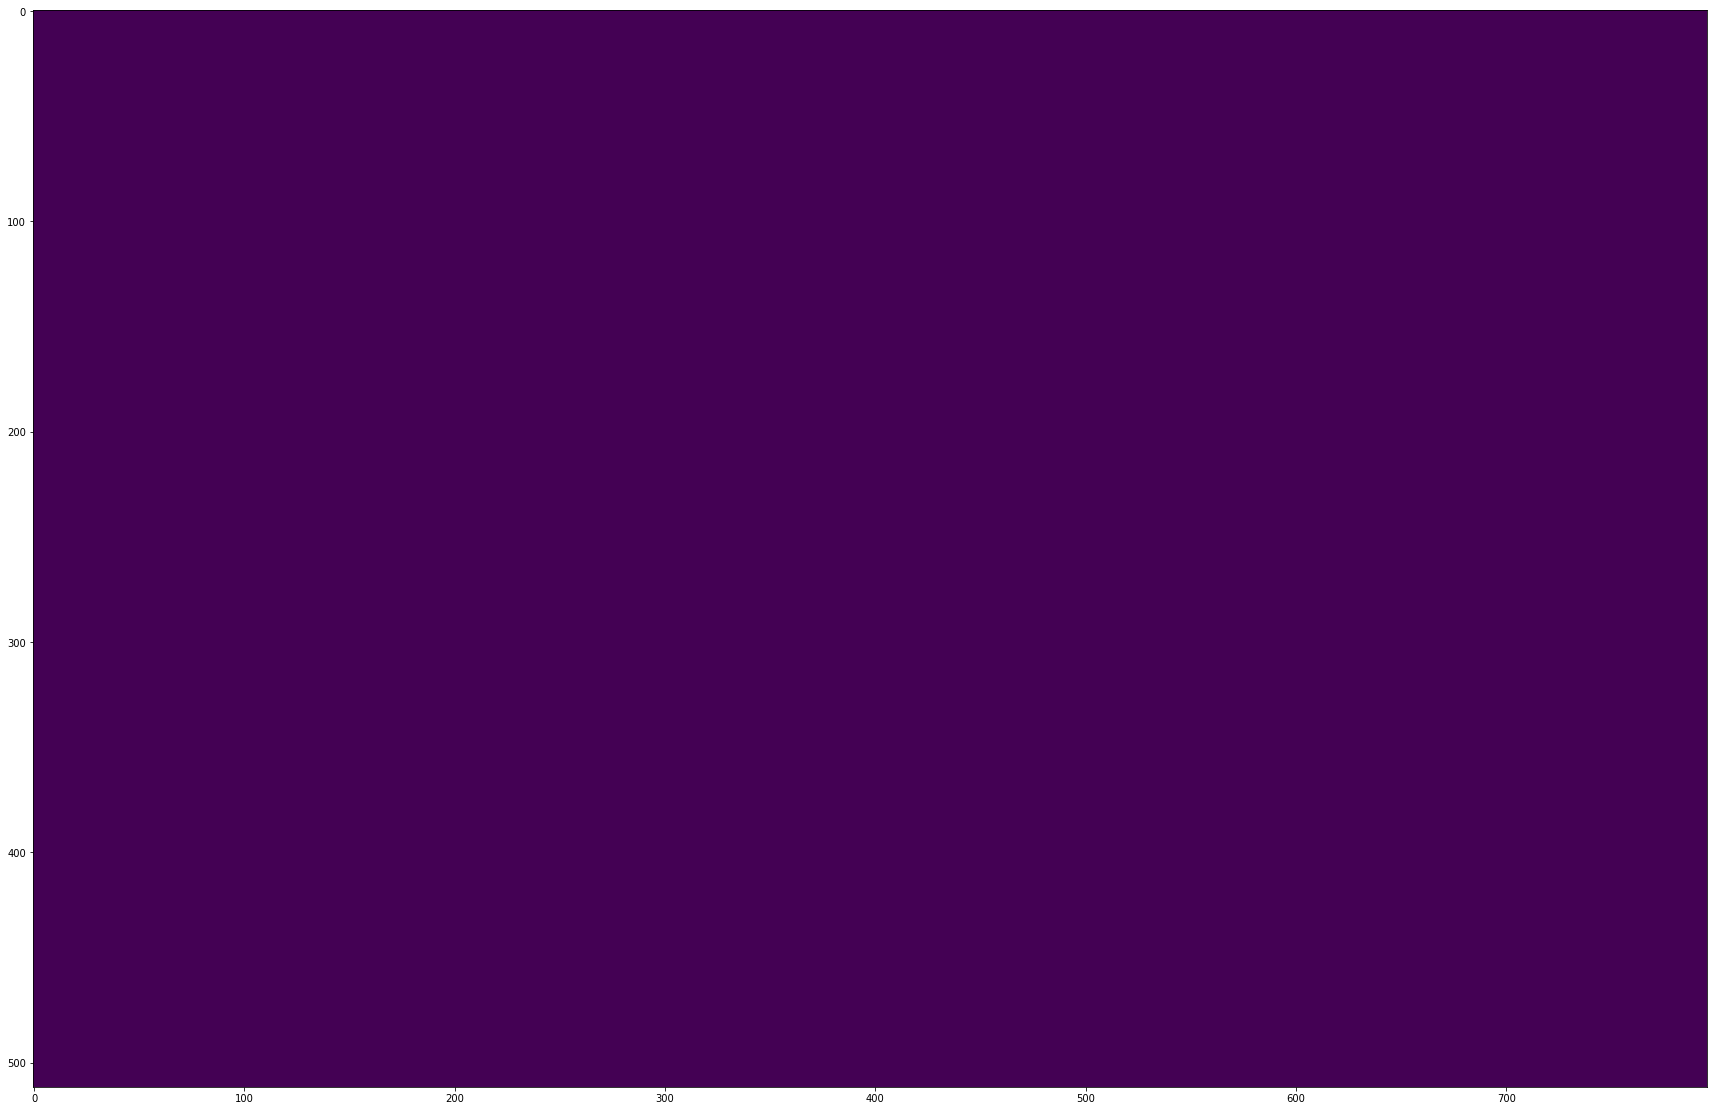

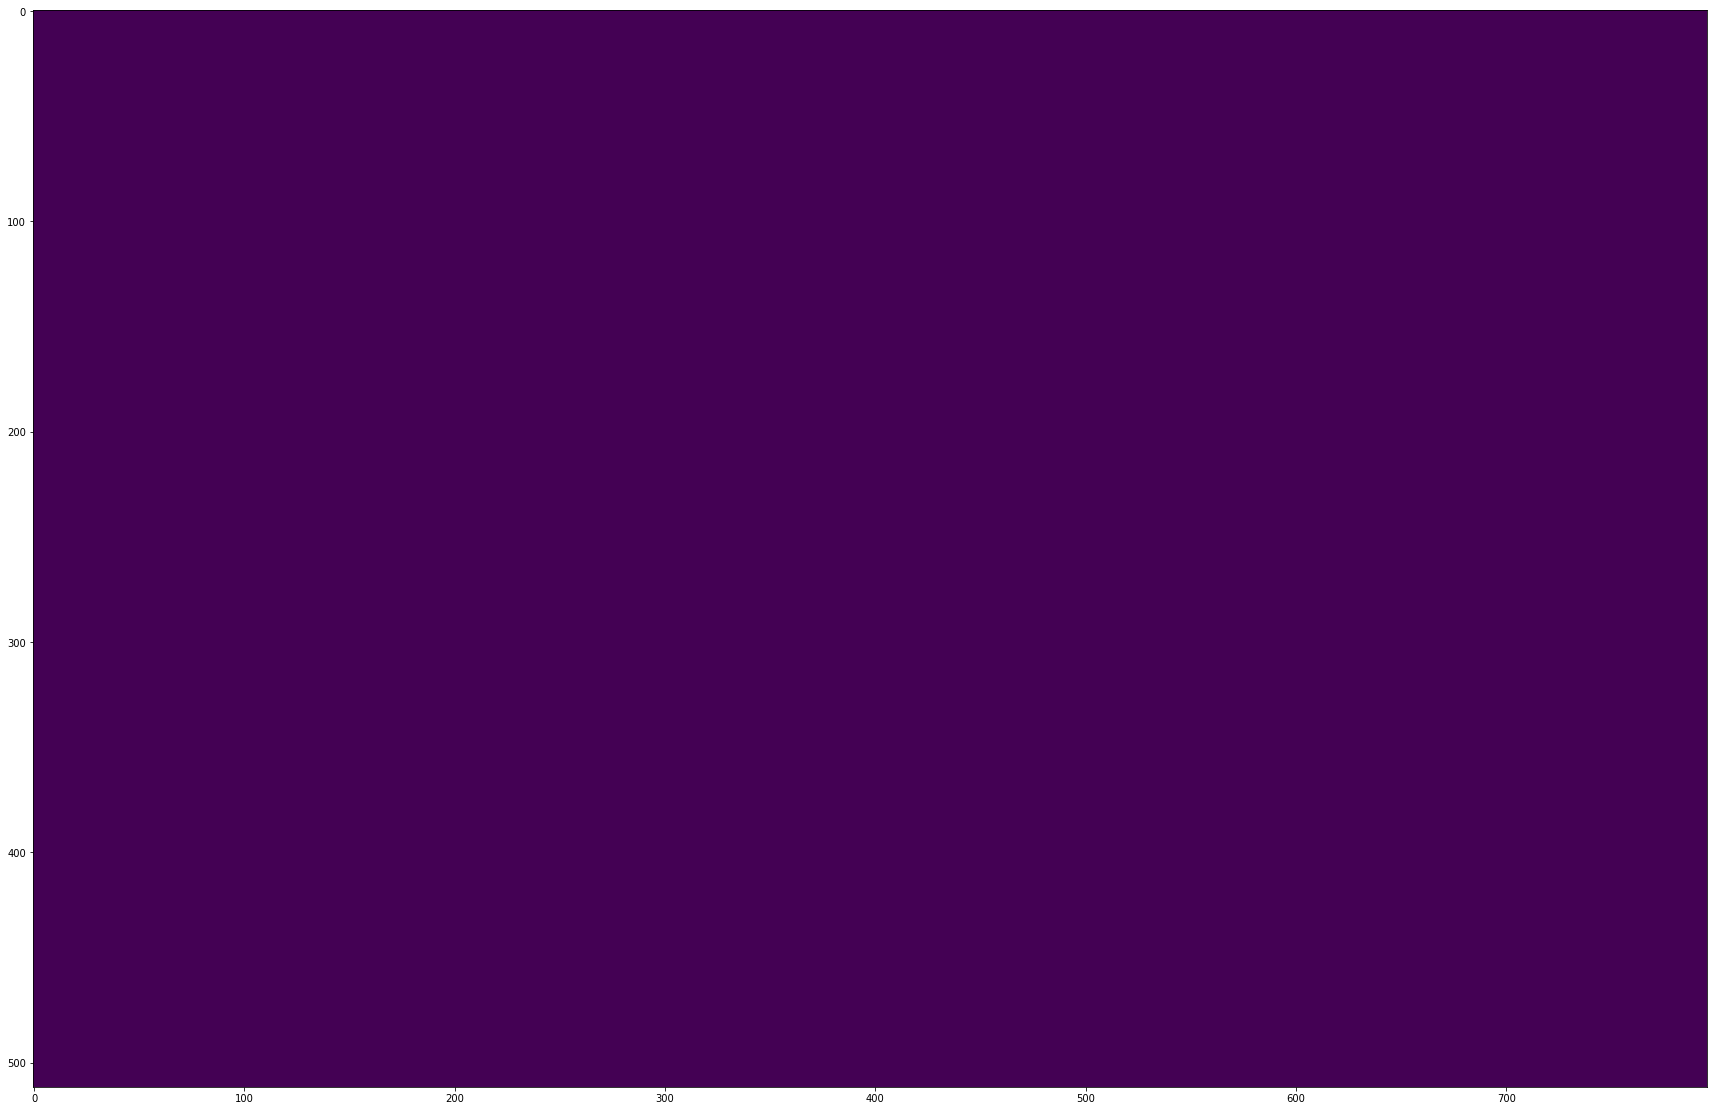

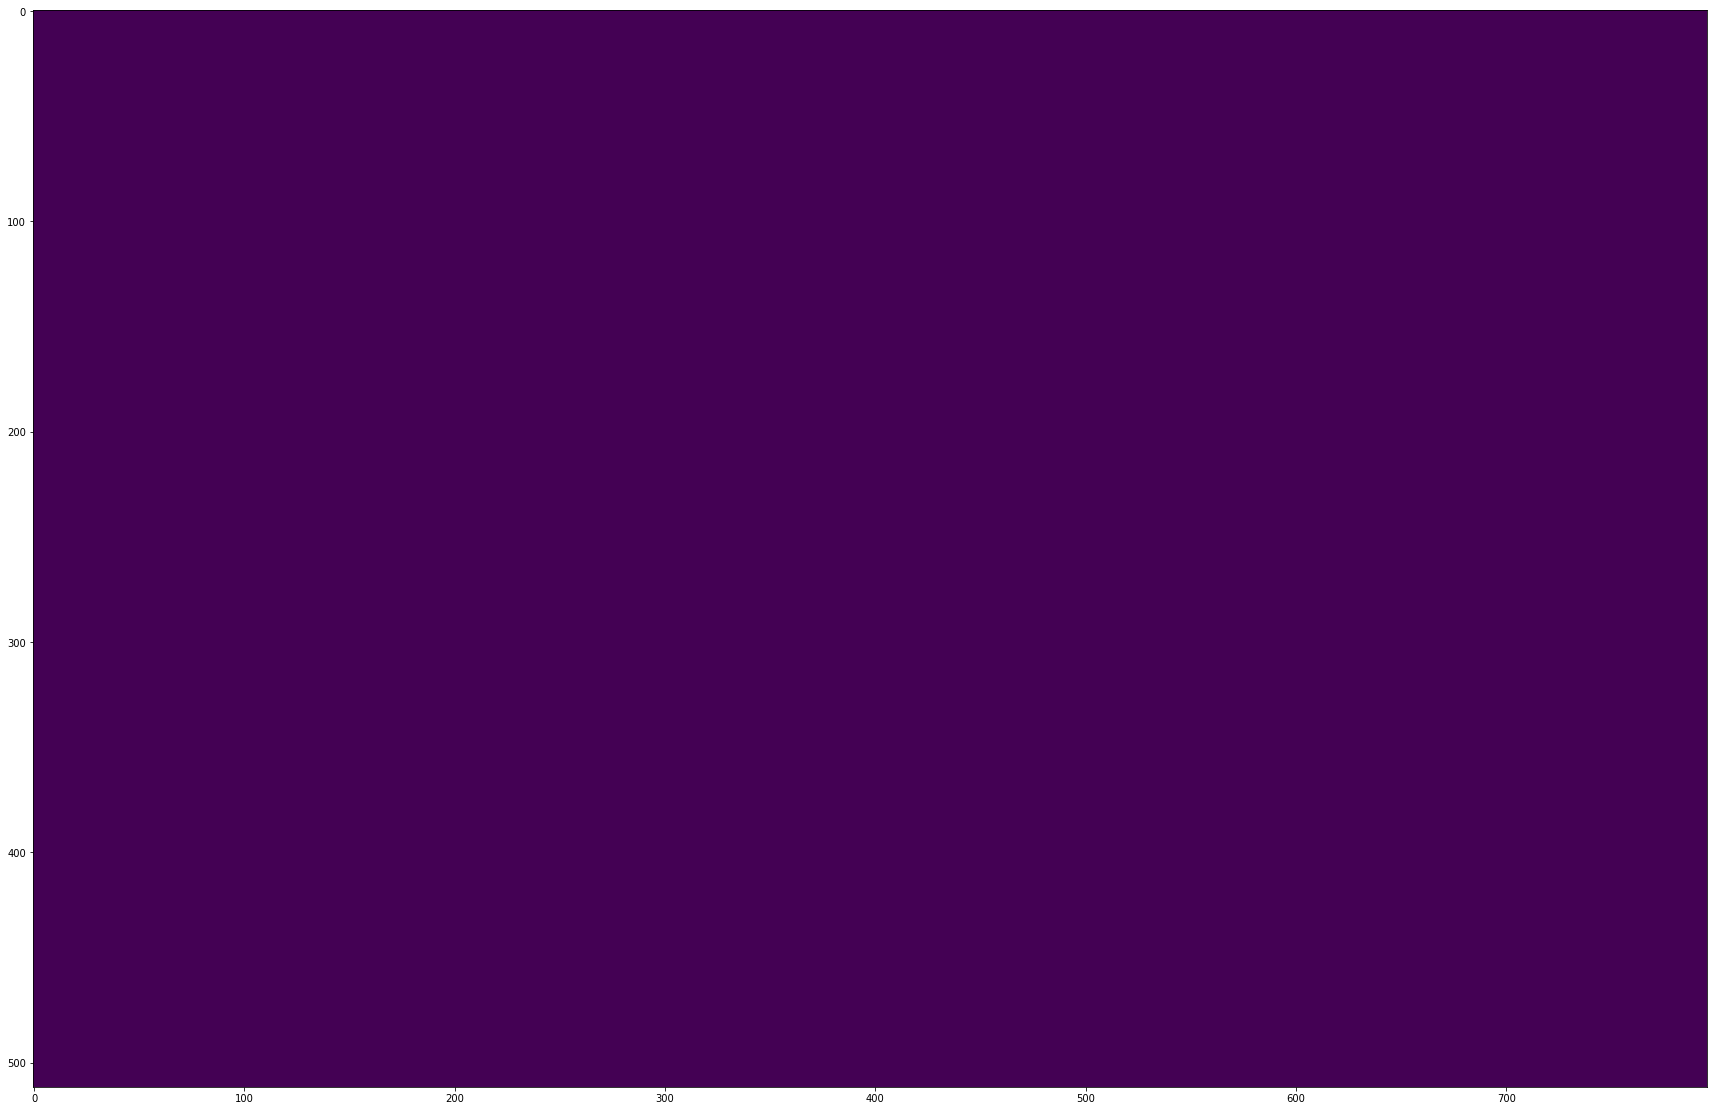

In [74]:
%matplotlib inline
for i in range(stack.shape[1]):
    fig, ax = plt.subplots(figsize = [30,20])
    ax.imshow(stack[0,i,:,:])
# fig.show()